<a href="https://colab.research.google.com/github/JHyunjun/TF2.0_Generative-Adversarial-Network/blob/main/GAN_JSAE_delta_250309.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# tf.config.list_physical_devices('GPU')

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9
   Current    SOC  Voltage   △I   △V
0    -13.7  100.0    746.3  0.0  0.0
1    -14.0  100.0    746.4 -0.3  0.1
2    -13.8  100.0    746.2  0.2 -0.2
3    -14.1  100.0    746.3 -0.3  0.1
4    -13.9  100.0    746.1  0.2 -0.2


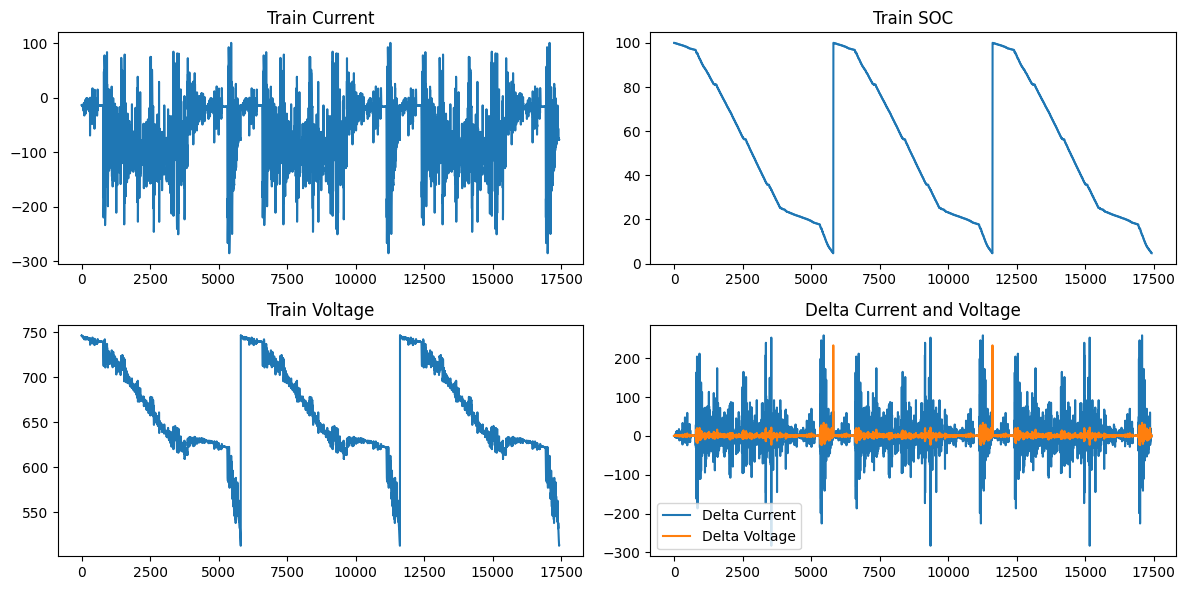

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Flatten, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay

tf.keras.mixed_precision.set_global_policy('mixed_float16')


import numpy as np
import matplotlib.pyplot as plt

def MinMaxScaler(data, data_min, data_max): # Scaling to 0~1
    return (data - data_min) / (data_max - data_min + 1e-7)

def min_max_scaler_neg1_to_1(data, data_min, data_max): # Scailing to -1~1 for tanh
    # data_min, data_max는 각각 각 피처의 최소, 최대값 (numpy array)
    return 2 * (data - data_min) / (data_max - data_min + 1e-7) - 1

def denormalize_feature(data, feature_index, data_min, data_max):
    # data: numpy array with shape (..., features)
    # 개별 피처(feature_index)에 대해 de-normalize 수행
    return data[..., feature_index] * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

train_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt", delimiter=",")
test_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt", delimiter=",")

# 데이터 반복 (예: train_data를 3배 반복)
train_data = pd.concat([train_data, train_data, train_data], ignore_index=True)

# 필요한 열만 선택 (예: 0,2,4번 열)
train_data = train_data.iloc[:, [0, 2, 4]]
cols = ['Current', 'SOC', 'Voltage']
train_data.columns = cols

test_data = test_data.iloc[:, [0, 2, 4]]
test_data.columns = cols

# △I, △V 열 추가: 각 행의 현재 값과 바로 이전 행의 차이 (첫 행은 0으로 채움)
train_data['△I'] = train_data['Current'].diff().fillna(0)
train_data['△V'] = train_data['Voltage'].diff().fillna(0)

# 추가된 열 확인
print(train_data.head())

# 플롯 예시 (기존 플롯에 추가 열도 그려볼 수 있음)
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(train_data['Current'])
plt.title("Train Current")

plt.subplot(2, 2, 2)
plt.plot(train_data['SOC'])
plt.title("Train SOC")

plt.subplot(2, 2, 3)
plt.plot(train_data['Voltage'])
plt.title("Train Voltage")

plt.subplot(2, 2, 4)
plt.plot(train_data['△I'], label="Delta Current")
plt.plot(train_data['△V'], label="Delta Voltage")
plt.title("Delta Current and Voltage")
plt.legend()
plt.tight_layout()
plt.show()

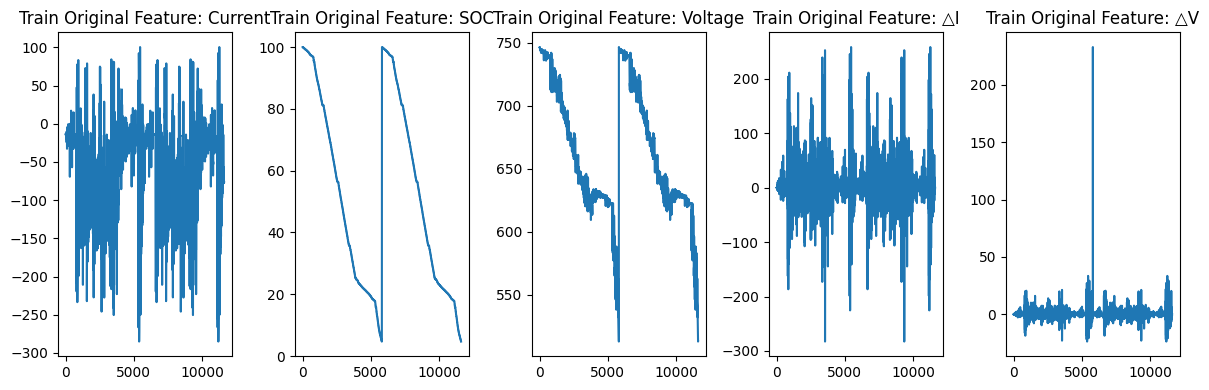

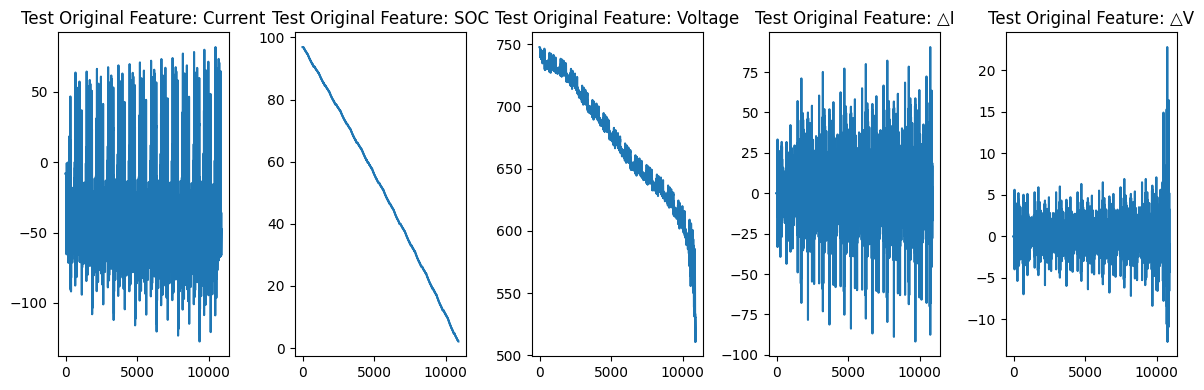

Scaled Train data :
 [[0.70383817 1.         0.99450549 0.52226122 0.09236165]
 [0.70306017 1.         0.99492815 0.521707   0.09275136]
 [0.70357884 1.         0.99408284 0.5226307  0.09158223]
 ...
 [0.54149378 0.02655771 0.01183432 0.52189174 0.09002338]
 [0.54175311 0.02655771 0.00887574 0.52244596 0.08963367]
 [0.5409751  0.02655771 0.0101437  0.521707   0.09353079]]
Scaled Test data :
 [[0.71810166 0.96833503 1.         0.52226122 0.09236165]
 [0.71810166 0.96833503 1.         0.52226122 0.09236165]
 [0.71810166 0.96833503 1.         0.52226122 0.09236165]
 ...
 [0.57131743 0.         0.01690617 0.521707   0.08222915]
 [0.57053942 0.         0.00803043 0.521707   0.08417771]
 [0.57002075 0.         0.         0.52189174 0.08495713]]
Scaled Combined data:
 (22496, 5) [[-1.370e+01  1.000e+02  7.463e+02  0.000e+00  0.000e+00]
 [-1.400e+01  1.000e+02  7.464e+02 -3.000e-01  1.000e-01]
 [-1.380e+01  1.000e+02  7.462e+02  2.000e-01 -2.000e-01]
 ...
 [-6.480e+01  2.100e+00  5.150e+02 -3.

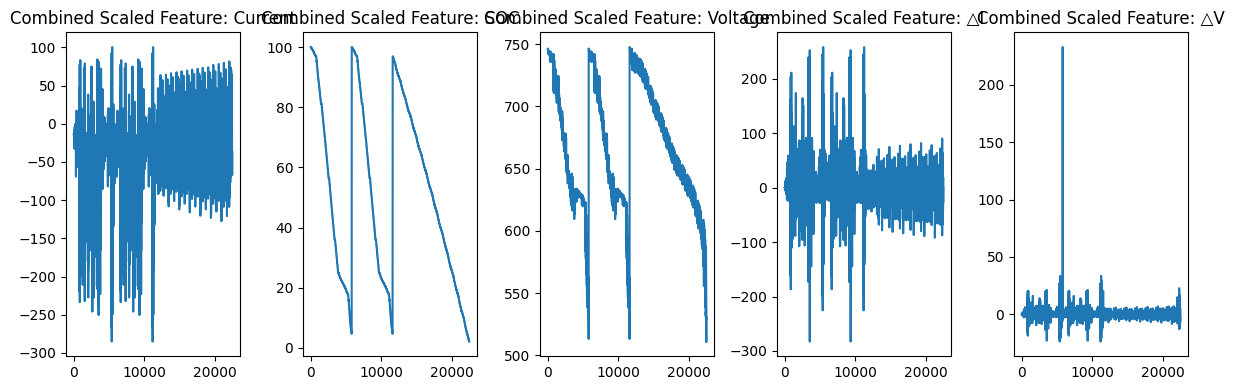

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Mixed precision 설정
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Scaling 함수들
def MinMaxScaler(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min + 1e-7)

def min_max_scaler_neg1_to_1(data, data_min, data_max):
    return 2 * (data - data_min) / (data_max - data_min + 1e-7) - 1

def denormalize_feature(data, feature_index, data_min, data_max):
    return data[..., feature_index] * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

def denorm_vector(vec, feature_index, data_min, data_max):
    return vec * (data_max[feature_index] - data_min[feature_index]) + data_min[feature_index]

# 데이터 로드
train_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt", delimiter=",")
test_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt", delimiter=",")

# train_data를 3배 반복 (원하는 경우)
train_data = pd.concat([train_data, train_data], ignore_index=True)

# 필요한 열만 선택: 여기서는 0번(Current), 2번(SOC), 4번(Pack Voltage)을 사용
train_data = train_data.iloc[:, [0, 2, 4]]
test_data = test_data.iloc[:, [0, 2, 4]]
# 열 이름 지정
cols = ['Current', 'SOC', 'Voltage']
train_data.columns = cols
test_data.columns = cols

# △I, △V 열 추가 (각 행에서 이전 행과의 차이; 첫 행은 0으로 채움)
train_data['△I'] = train_data['Current'].diff().fillna(0)
train_data['△V'] = train_data['Voltage'].diff().fillna(0)
test_data['△I'] = test_data['Current'].diff().fillna(0)
test_data['△V'] = test_data['Voltage'].diff().fillna(0)

# 새 열 이름: 이제 총 5개 열
cols = ['Current', 'SOC', 'Voltage', '△I', '△V']

# 데이터 시각화: 각 피처 확인
plt.figure(figsize=(12, 4))
for i in range(train_data.shape[1]):
    plt.subplot(1, train_data.shape[1], i+1)
    plt.plot(train_data.iloc[:, i])
    plt.title(f"Train Original Feature: {cols[i]}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(test_data.shape[1]):
    plt.subplot(1, test_data.shape[1], i+1)
    plt.plot(test_data.iloc[:, i])
    plt.title(f"Test Original Feature: {cols[i]}")
plt.tight_layout()
plt.show()

# Data Normalization (0~1)
combined_data = pd.concat([train_data, test_data], ignore_index=True)
data_min = combined_data.min().values
data_max = combined_data.max().values
train_scaled = MinMaxScaler(train_data.values, data_min, data_max)
test_scaled = MinMaxScaler(test_data.values, data_min, data_max)
print("Scaled Train data :\n", train_scaled)
print("Scaled Test data :\n", test_scaled)
print("Scaled Combined data:\n", combined_data.shape, combined_data.values)

# Data Slicing (여기서는 overlap=0.8 사용, 즉 stride = int(window_size * (1-0.8)) = int(20*0.2)=4)
window_size = 60
overlap_factor = 0.8

def create_sequences_non_overlapping(data, window_size=window_size, overlap=overlap_factor):
    stride = int(window_size * (1 - overlap))
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

train_sequences = create_sequences_non_overlapping(train_scaled, window_size=window_size, overlap=overlap_factor)
all_sequences = create_sequences_non_overlapping(np.concatenate([train_scaled, test_scaled], axis=0), window_size=window_size, overlap=overlap_factor)

print("Train data.shape : ", train_scaled.shape)
print("Train sequences shape : ", train_sequences.shape)
print("All data.shape : ", combined_data.shape)
print("All sequences shape : ", all_sequences.shape)

# Combined 데이터 시각화
plt.figure(figsize=(12, 4))
for i in range(combined_data.shape[1]):
    plt.subplot(1, combined_data.shape[1], i+1)
    plt.plot(combined_data.iloc[:, i])
    plt.title(f"Combined Scaled Feature: {cols[i]}")
plt.tight_layout()
plt.show()


Teacher X shape: (2040, 60, 4)
Teacher Y shape: (2040, 60, 1)
1/1 [==============================] - 4s 4s/step


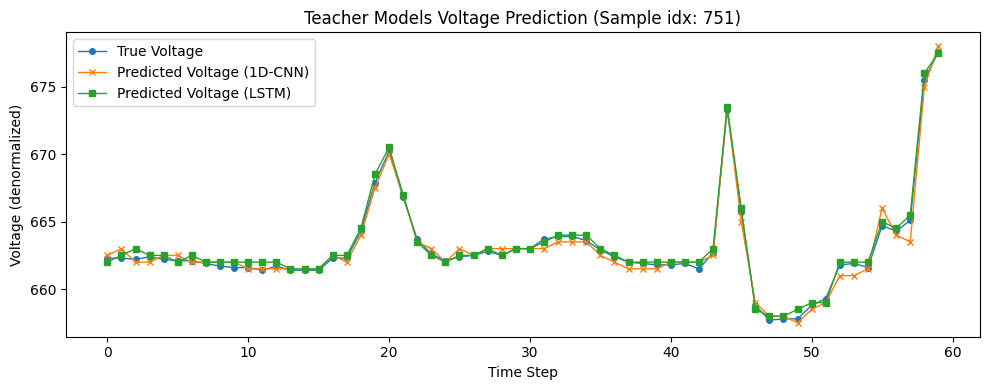

1/1 [==============================] - 0s 23ms/step


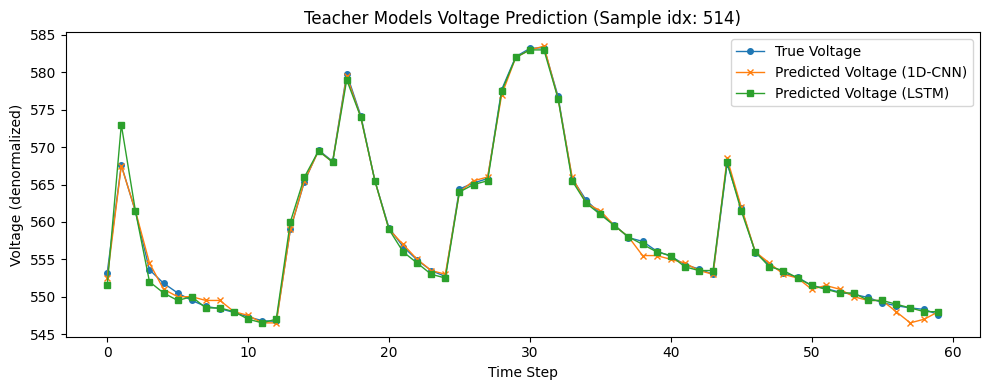

1/1 [==============================] - 0s 23ms/step


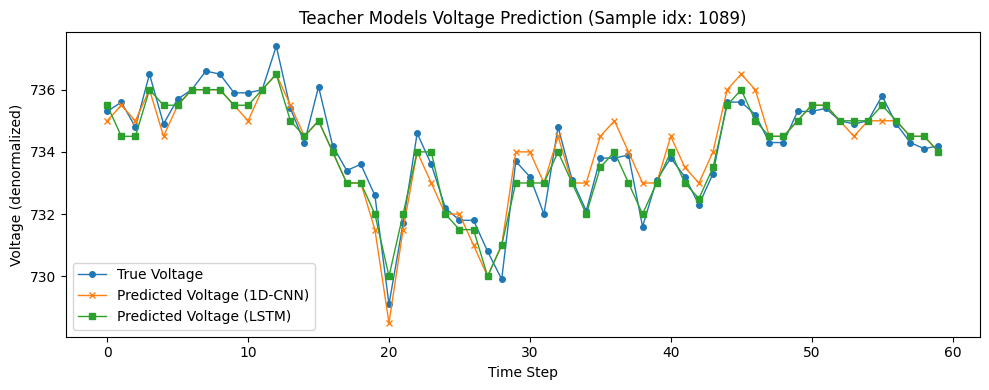

1/1 [==============================] - 0s 23ms/step


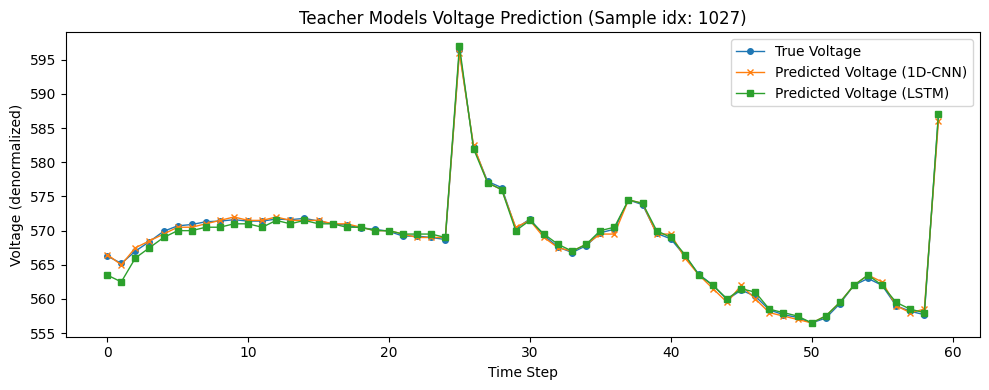

1/1 [==============================] - 0s 22ms/step


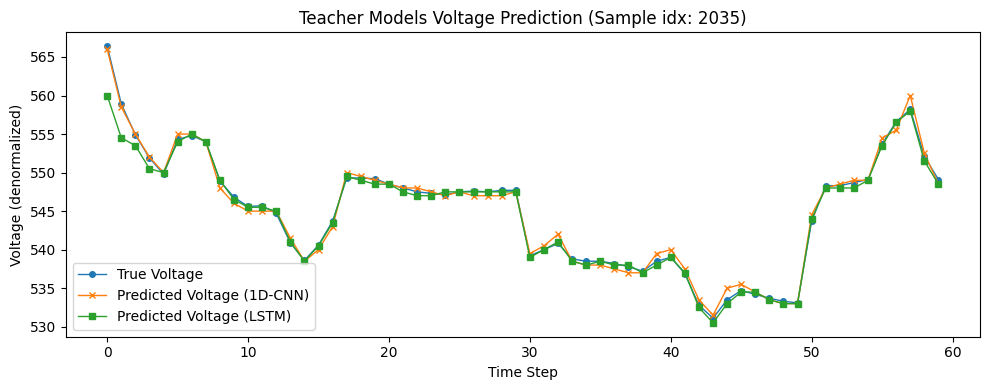

1/1 [==============================] - 0s 24ms/step


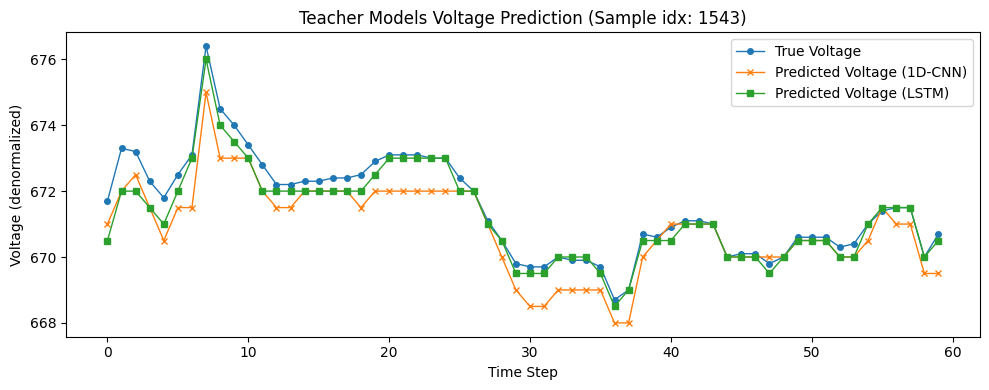

1/1 [==============================] - 0s 22ms/step


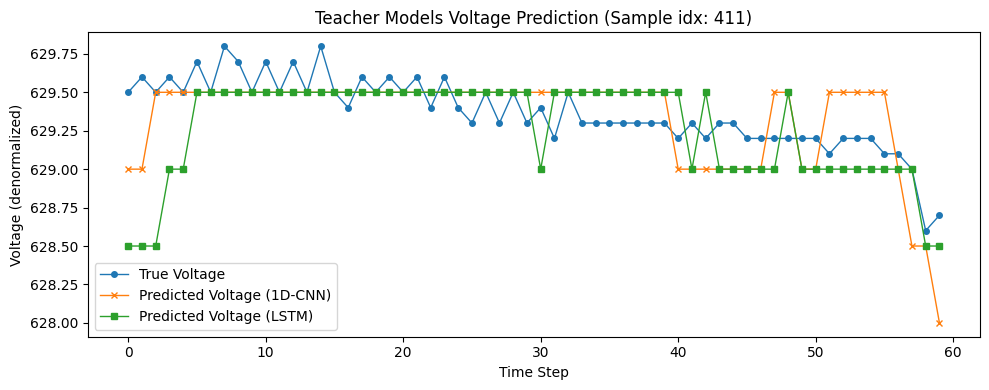

1/1 [==============================] - 0s 20ms/step


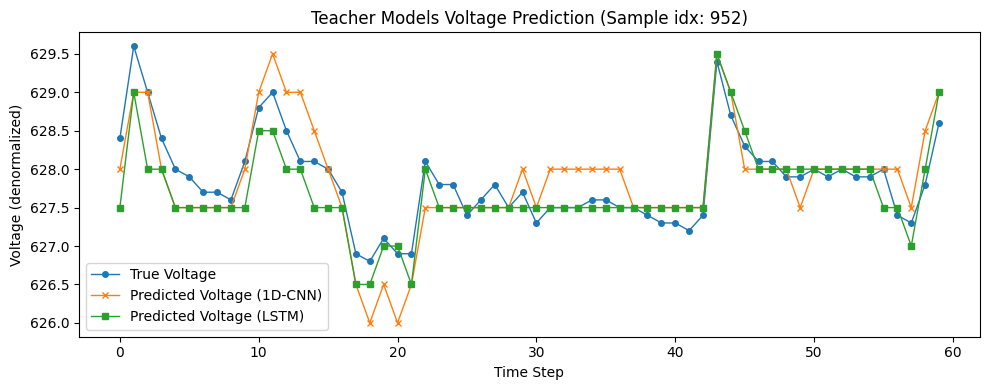

1/1 [==============================] - 0s 26ms/step


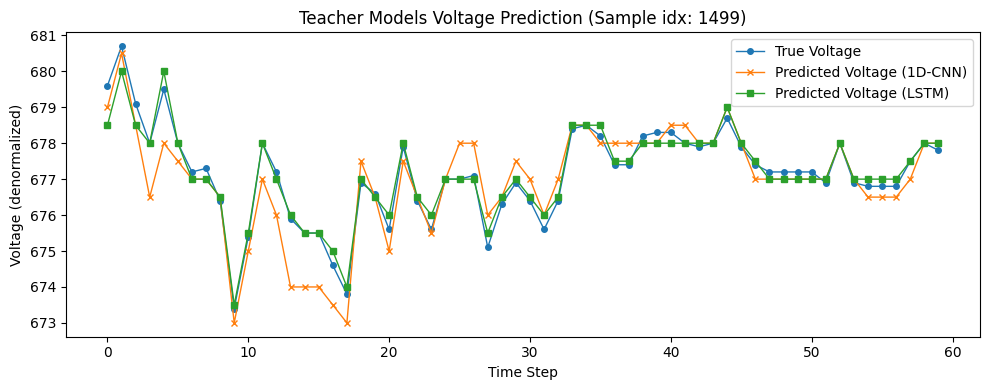

1/1 [==============================] - 0s 21ms/step


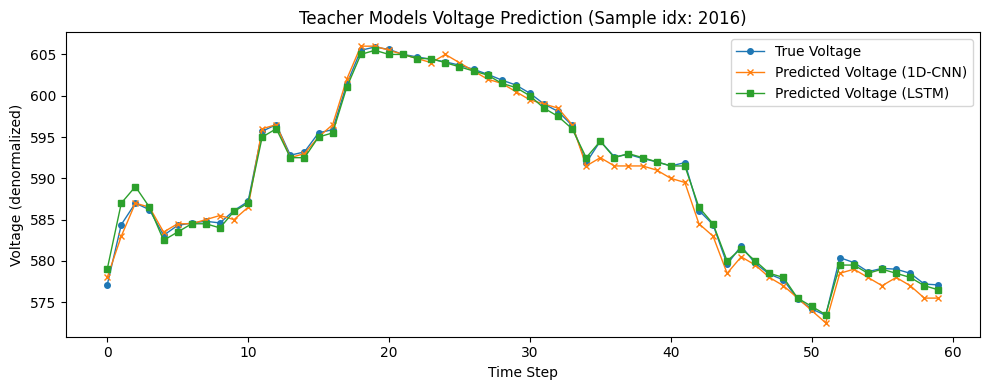

64/64 [==============================] - 1s 9ms/step


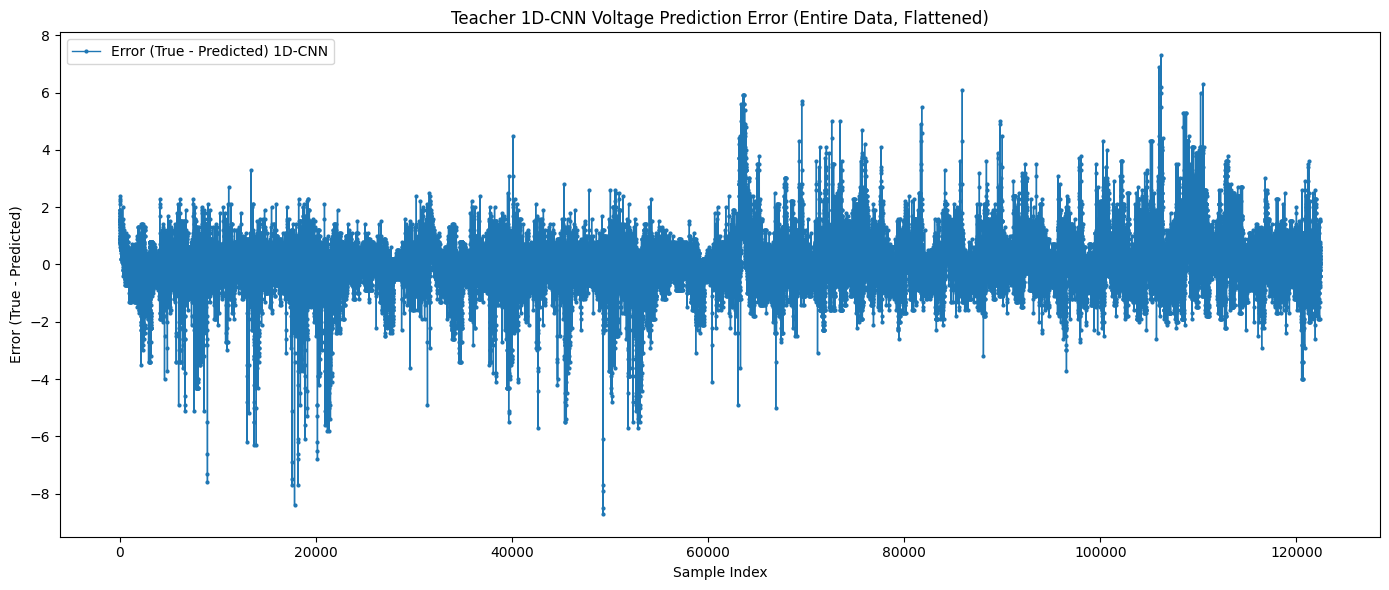

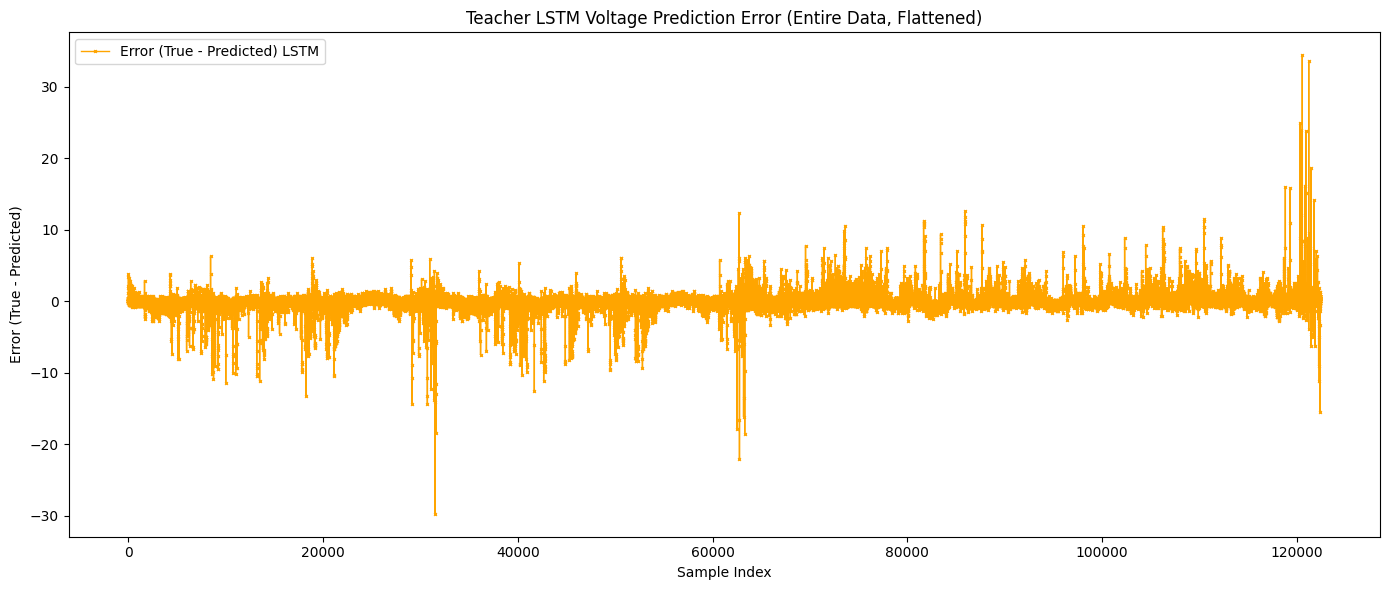

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Mixed precision 설정 (옵션)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 3. Teacher 모델 학습 데이터 구성
############################################

# Teacher 모델 입력: [Current, SOC, △I, △V] → 인덱스 [0,1,3,4]
# Teacher 모델 출력: [Voltage] → 인덱스 [2]
teacher_X = all_sequences[..., [0, 1, 3, 4]]  # (N, window_size, 4)
teacher_Y = all_sequences[..., 2:3]           # (N, window_size, 1)

print("Teacher X shape:", teacher_X.shape)
print("Teacher Y shape:", teacher_Y.shape)

############################################
# 4. Teacher 모델 정의 & 학습 (Learning Rate Decay 포함)
############################################

# Learning Rate Scheduler: 매 200 epoch마다 lr를 0.95배로 감소
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 100 == 0:
        return lr * 0.9
    return lr

lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

# 4.1 1D-CNN Teacher 모델
# def build_teacher_1d_cnn(input_shape):
#     inp = Input(shape=input_shape)  # (window_size, 4)
#     x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(inp)
#     x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
#     x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
#     x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
#     out = Conv1D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(x)
#     model = Model(inp, out, name="Teacher_1D_CNN")
#     return model

# teacher_1d = build_teacher_1d_cnn((window_size, 4))
# teacher_1d.summary()
# teacher_1d.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# history_1d = teacher_1d.fit(teacher_X, teacher_Y,
#                              epochs=5000,
#                              batch_size=64,
#                              callbacks=[lr_callback],
#                              verbose=1)

# teacher_1d.save("refined_1d_cnn_deltaiv.h5")
# print("1D-CNN Teacher model saved as refined_1d_cnn_deltaiv.h5")

teacher_1d = tf.keras.models.load_model("refined_1d_cnn_deltaiv.h5")

# 4.2 LSTM Teacher 모델
# def build_teacher_lstm(input_shape):
#     inp = Input(shape=input_shape, dtype='float32')
#     x = LSTM(128, return_sequences=True)(inp)
#     x = LSTM(128, return_sequences=True)(x)
#     x = LSTM(64, return_sequences=True)(x)
#     x = LSTM(64, return_sequences=True)(x)
#     out = TimeDistributed(Dense(1, activation='sigmoid'))(x)
#     model = Model(inp, out, name="Teacher_LSTM")
#     return model

# teacher_lstm = build_teacher_lstm((window_size, 4))
# teacher_lstm.summary()
# teacher_lstm.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# history_lstm = teacher_lstm.fit(teacher_X, teacher_Y,
#                                 epochs=3000,
#                                 batch_size=64,
#                                 callbacks=[lr_callback],
#                                 verbose=1)

# teacher_lstm.save("refined_lstm_deltaiv.h5")
# print("LSTM Teacher model saved as refined_lstm_deltaiv.h5")

teacher_lstm = tf.keras.models.load_model("refined_lstm_deltaiv.h5")


# denorm_vector 함수: vec는 1D 배열, feature_index는 전압에 해당하는 인덱스 (여기서는 2)
def denorm_vector(vec, feature_index, data_min, data_max):
    return vec * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

# teacher_X와 teacher_Y의 첫 번째 차원은 샘플 개수
num_samples = teacher_X.shape[0]
# 5개의 랜덤 샘플 인덱스 선택
random_indices = np.random.choice(num_samples, size=10, replace=False)

for idx in random_indices:
    # (1) 해당 샘플의 Teacher 입력과 정답 추출
    sample_input = teacher_X[idx:idx+1]  # shape: (1, window_size, 4)
    sample_true  = teacher_Y[idx:idx+1]   # shape: (1, window_size, 1)

    # (2) 각 Teacher 모델 예측
    pred_cnn = teacher_1d.predict(sample_input)    # (1, window_size, 1)
    pred_lstm = teacher_lstm.predict(sample_input)   # (1, window_size, 1)

    # (3) Flatten: (window_size,)
    pred_cnn_flat = pred_cnn.reshape(-1)
    pred_lstm_flat = pred_lstm.reshape(-1)
    true_flat = sample_true.reshape(-1)

    # (4) Denormalize: 전압은 feature index 2 사용 (data_min, data_max 배열 기준)
    true_denorm = denorm_vector(true_flat, 2, data_min, data_max)
    pred_cnn_denorm = denorm_vector(pred_cnn_flat, 2, data_min, data_max)
    pred_lstm_denorm = denorm_vector(pred_lstm_flat, 2, data_min, data_max)

    # (5) 플롯: 한 Figure에 실제 전압과 두 Teacher 모델 예측 전압 비교
    plt.figure(figsize=(10,4))
    plt.plot(true_denorm, label="True Voltage", marker='o', markersize=4, linewidth=1)
    plt.plot(pred_cnn_denorm, label="Predicted Voltage (1D-CNN)", marker='x', markersize=4, linewidth=1)
    plt.plot(pred_lstm_denorm, label="Predicted Voltage (LSTM)", marker='s', markersize=4, linewidth=1)
    plt.title(f"Teacher Models Voltage Prediction (Sample idx: {idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (denormalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Teacher 모델 예측 수행
pred_cnn = teacher_1d.predict(teacher_X)      # (N, window_size, 1)
pred_lstm = teacher_lstm.predict(teacher_X)     # (N, window_size, 1)
true_vals = teacher_Y                           # (N, window_size, 1)

# 전체 데이터를 1D 벡터로 flatten (N * window_size,)
pred_cnn_flat = pred_cnn.reshape(-1)
pred_lstm_flat = pred_lstm.reshape(-1)
true_flat = true_vals.reshape(-1)

# Denormalize: 전압은 원래 데이터에서 feature index 2 (즉, combined_data의 두번째 인덱스)에 해당
true_denorm = denorm_vector(true_flat, 2, data_min, data_max)
pred_cnn_denorm = denorm_vector(pred_cnn_flat, 2, data_min, data_max)
pred_lstm_denorm = denorm_vector(pred_lstm_flat, 2, data_min, data_max)

# 오차 계산: (실제 전압 - 예측 전압)
error_cnn = true_denorm - pred_cnn_denorm
error_lstm = true_denorm - pred_lstm_denorm

# 1D-CNN Teacher 모델 오차 플롯
plt.figure(figsize=(14,6))
plt.plot(error_cnn, label="Error (True - Predicted) 1D-CNN", marker='o', markersize=2, linewidth=1)
plt.title("Teacher 1D-CNN Voltage Prediction Error (Entire Data, Flattened)")
plt.xlabel("Sample Index")
plt.ylabel("Error (True - Predicted)")
plt.legend()
plt.tight_layout()
plt.show()

# LSTM Teacher 모델 오차 플롯
plt.figure(figsize=(14,6))
plt.plot(error_lstm, label="Error (True - Predicted) LSTM", marker='x', markersize=2, linewidth=1, color='orange')
plt.title("Teacher LSTM Voltage Prediction Error (Entire Data, Flattened)")
plt.xlabel("Sample Index")
plt.ylabel("Error (True - Predicted)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, ConvLSTM2D, TimeDistributed, Conv2D, Flatten, Input, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Hyper Parameters
feature_dim = 5        # 원본 all_sequences는 5채널: [전류, SOC, 전압, ΔI, ΔV]
latent_dim = 50      # 노이즈 차원
batch_size = 256
epochs = 1800
n_critic = 3
lambda_gp = 10.0
learning_rate = 5e-4

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# --- Gradient Penalty 계산 함수 (WGAN-GP) ---
@tf.function
def gradient_penalty(discriminator, real_samples, fake_samples):
    fake_samples = tf.cast(fake_samples, real_samples.dtype)
    batch_size = tf.shape(real_samples)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0, dtype=real_samples.dtype)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = tf.reduce_mean((grad_norm - 1.0) ** 2)
    return gp

teacher_model = tf.keras.models.load_model("refined_1d_cnn_deltaiv.h5")
teacher_model_2 = tf.keras.models.load_model("refined_lstm_deltaiv.h5")
teacher_model.trainable = False
teacher_model_2.trainable = False

# --- Generator ---
# get_condition: 조건으로 SOC를 추출 (여전히 사용하지만 최종 출력에는 반영하지 않습니다)
##################################################### End of Window SOC
# def get_condition(real_series):
#     # real_series: (batch, window_size, feature_dim)
#     # 조건: SOC는 두번째 피처
#     soc = real_series[:, -1, 1]       # (batch,)
#     soc = tf.expand_dims(soc, axis=1)   # (batch, 1)
#     soc = tf.tile(soc, [1, window_size])# (batch, window_size)
#     soc = tf.expand_dims(soc, axis=-1)  # (batch, window_size, 1)
#     return soc
##################################################### Average SOC
def get_condition(real_series):
    """
    real_series: (batch, window_size, feature_dim)
    조건: SOC는 두번째 피처.
    각 윈도우 내 SOC의 평균값을 계산한 후, 이를 window_size번 복제하여 (batch, window_size, 1)로 반환.
    """
    soc_mean = tf.reduce_mean(real_series[..., 1], axis=1, keepdims=True)  # (batch, 1)
    soc_mean_tiled = tf.tile(soc_mean, [1, real_series.shape[1]])          # (batch, window_size)
    return tf.expand_dims(soc_mean_tiled, axis=-1)                         # (batch, window_size, 1)


# Generator는 노이즈와 조건(SOC)을 받아 동적 피처로 [전류, ΔI, ΔV, 전압] (4채널)를 생성하도록 구성하고,
# 최종 combine_output은 조건을 무시하고 Generator 출력 그대로 반환하여 최종 생성 시퀀스가 [전류, SOC, ΔI, ΔV]가 아니라
# [전류, ΔI, ΔV, 전압]을 생성하도록 합니다.
# 여기서 우리가 원하는 최종 ordering는: [전류, ΔI, ΔV, 전압]
def build_generator_cond(latent_dim, window_size):
    noise_inp = Input(shape=(window_size, latent_dim))
    cond_inp = Input(shape=(window_size, 1))
    x = Concatenate(axis=-1)([noise_inp, cond_inp])
    x = TimeDistributed(Dense(64))(x)
    x = TimeDistributed(LeakyReLU(alpha=0.2))(x)
    x = Reshape((window_size, 1, 64, 1))(x)
    x = ConvLSTM2D(filters=32, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=32, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=32, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=32, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=32, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = TimeDistributed(Conv2D(filters=1, kernel_size=(1,3), padding='same'))(x)
    x = TimeDistributed(LeakyReLU(alpha=0.2))(x)
    x = TimeDistributed(Flatten())(x)
    # 최종 출력: Dense(4, activation='sigmoid') → 4채널: [전류, ΔI, ΔV, 전압]
    dynamic_out = TimeDistributed(Dense(4, activation='sigmoid'))(x)
    model = Model([noise_inp, cond_inp], dynamic_out, name="Generator_Conditional")
    return model

# combine_output: Generator의 동적 출력 이미 4채널이므로 그대로 반환
def combine_output(dynamic, cond):
    return dynamic

generator_cond = build_generator_cond(latent_dim, window_size)

# --- Discriminator ---
# 최종 생성 시퀀스: [전류, ΔI, ΔV, 전압] → 4채널
def build_discriminator(input_shape):
    model = Sequential(name="Critic")
    # 입력 shape: (window_size, 4)
    window_size = input_shape[0]
    num_features = input_shape[1]
    model.add(Reshape((window_size, 1, num_features, 1), input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, num_features), padding='same', return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(ConvLSTM2D(filters=16, kernel_size=(1, num_features), padding='same', return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(ConvLSTM2D(filters=8, kernel_size=(1, num_features), padding='same', return_sequences=False))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1))
    return model

discriminator = build_discriminator((window_size, 4))

# --- Optimizers and Dataset ---
generator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
dataset = tf.data.Dataset.from_tensor_slices(all_sequences.astype('float32')).shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# -----------------------------
# Training Step
# -----------------------------
@tf.function
def train_step(real_series):
    # real_series: (batch, window_size, feature_dim) → feature_dim=5, 순서: [전류, SOC, 전압, ΔI, ΔV]
    # 1. Discriminator 업데이트
    cond = get_condition(real_series)  # (batch, window_size, 1)
    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim])
    latent_fake = generator_cond([noise, cond], training=True)  # (batch, window_size, 4)
    fake_series = combine_output(latent_fake, cond)  # (batch, window_size, 4), ordering: [전류, ΔI, ΔV, 전압]

    # real_series의 Discriminator 입력: 사용하려는 채널: [전류, ΔI, ΔV, 전압] → 열 인덱스 [0,3,4,2]
    real_for_disc = tf.stack([real_series[..., 0], real_series[..., 3], real_series[..., 4], real_series[..., 2]], axis=-1)

    with tf.GradientTape() as tape:
        d_real = discriminator(real_for_disc, training=True)
        d_fake = discriminator(fake_series, training=True)
        d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        gp = gradient_penalty(discriminator, real_for_disc, fake_series)
        d_loss_total = d_loss + tf.cast(lambda_gp, d_loss.dtype) * tf.cast(gp, d_loss.dtype)
    gradients = tape.gradient(d_loss_total, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # 2. Generator 업데이트
    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim])
    with tf.GradientTape() as tape:
        latent_fake = generator_cond([noise, cond], training=True)
        fake_series = combine_output(latent_fake, cond)  # (batch, window_size, 4)
        d_fake = discriminator(fake_series, training=True)
        g_adv_loss = -tf.reduce_mean(d_fake)

        # Teacher 모델을 이용한 supervised loss 계산
        # Teacher 모델은 [전류, SOC, ΔI, ΔV] (채널 0,)를 입력으로 받아 전압을 예측함.
        teacher_input = tf.concat([
            fake_series[..., :1],               # 전류 (채널 0)
            tf.cast(cond, fake_series.dtype),    # SOC (조건, 채널 1)
            fake_series[..., 1:3]                # 델타 i, 델타 v (채널 2~3)
        ], axis=-1)  # 최종 teacher_input shape: (batch, window_size, 4)

        teacher_prediction = teacher_model(teacher_input, training=False)  # (batch, window_size, 1)
        teacher_prediction_2 = teacher_model_2(teacher_input, training=False)
        # 실제 생성된 전압: fake_series의 채널 3 (shape: (batch, window_size, 1))
        teacher_loss = tf.reduce_mean(tf.square(teacher_prediction - tf.cast(fake_series[..., 3:4], teacher_prediction.dtype)))
        teacher_loss_2 = tf.reduce_mean(tf.square(teacher_prediction_2 - tf.cast(fake_series[..., 3:4], teacher_prediction_2.dtype)))

        alpha = 3.0
        beta = 3.0
        g_loss_total = g_adv_loss + tf.cast(alpha * teacher_loss, g_adv_loss.dtype) + tf.cast(beta * teacher_loss_2, g_adv_loss.dtype)
    gradients = tape.gradient(g_loss_total, generator_cond.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator_cond.trainable_variables))

    return d_loss, g_loss_total, gp


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# 예시 하이퍼파라미터
initial_lr = learning_rate
decay_rate = 0.95  # 100 epoch마다 적용할 decay factor
epoch_decay = 100
# Optimizer 생성 (초기 lr로 설정)
generator_optimizer = Adam(learning_rate=initial_lr, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=initial_lr, beta_1=0.5, beta_2=0.9)

# Training Loop 내에서 매 100 epoch마다 lr 업데이트
for epoch in range(epochs):
    if epoch % epoch_decay == 0 and epoch != 0:
        # 매 100 epoch마다 새로운 lr 계산:
        # new_lr = initial_lr * (decay_rate ** (epoch // 100))
        new_lr = initial_lr * (decay_rate ** (epoch // epoch_decay))
        generator_optimizer.learning_rate.assign(new_lr)
        discriminator_optimizer.learning_rate.assign(new_lr)
    # 학습 루프 수행 (여기서는 기존 train_step 함수와 dataset 사용)
    total_d, total_g, total_gp, count = 0.0, 0.0, 0.0, 0
    for real_batch in dataset:
        d_loss_val, g_loss_val, gp_val = train_step(real_batch)
        total_d += d_loss_val
        total_g += g_loss_val
        total_gp += gp_val
        count += 1
    if epoch % 100 == 0:
        current_lr = generator_optimizer.learning_rate.numpy()
        print(f"Epoch {epoch} | lr: {current_lr:.6f} | D Loss: {total_d/count:.4f}, GP: {total_gp/count:.4f}, G Loss: {total_g/count:.4f}")

generator_cond.save("250309_gan_generator.h5")
print("Generator model saved as 250309_gan_generator.h5")


Epoch 0 | lr: 0.000500 | D Loss: -0.0000, GP: 0.9390, G Loss: 0.6929
Epoch 100 | lr: 0.000475 | D Loss: 0.2073, GP: 0.0144, G Loss: -0.1807
Epoch 200 | lr: 0.000451 | D Loss: 0.2371, GP: 0.0335, G Loss: 0.6606
Epoch 300 | lr: 0.000429 | D Loss: 0.1879, GP: 0.0174, G Loss: 0.1593
Epoch 400 | lr: 0.000407 | D Loss: 0.2040, GP: 0.0061, G Loss: -0.2939
Epoch 500 | lr: 0.000387 | D Loss: 0.1881, GP: 0.0078, G Loss: -0.2952
Epoch 600 | lr: 0.000368 | D Loss: 0.1484, GP: 0.0288, G Loss: -0.5073
Epoch 700 | lr: 0.000349 | D Loss: 0.1434, GP: 0.0043, G Loss: -0.5234
Epoch 800 | lr: 0.000332 | D Loss: 0.1292, GP: 0.0051, G Loss: -0.3020
Epoch 900 | lr: 0.000315 | D Loss: 0.1300, GP: 0.0023, G Loss: -0.6333
Epoch 1000 | lr: 0.000299 | D Loss: 0.1188, GP: 0.0009, G Loss: -0.5688
Epoch 1100 | lr: 0.000284 | D Loss: nan, GP: nan, G Loss: nan
Generator model saved as 250309_gan_generator.h5


In [ ]:
print("data_min : ", data_min)
print("data_max : ", data_max)

data_min :  [-285.1    2.1  511.  -282.7  -23.7]
data_max :  [100.5 100.  747.6 258.6 232.9]


Latnent dynamic.shape : (1, 60, 4)
Generated sequence shape: (1, 60, 5)


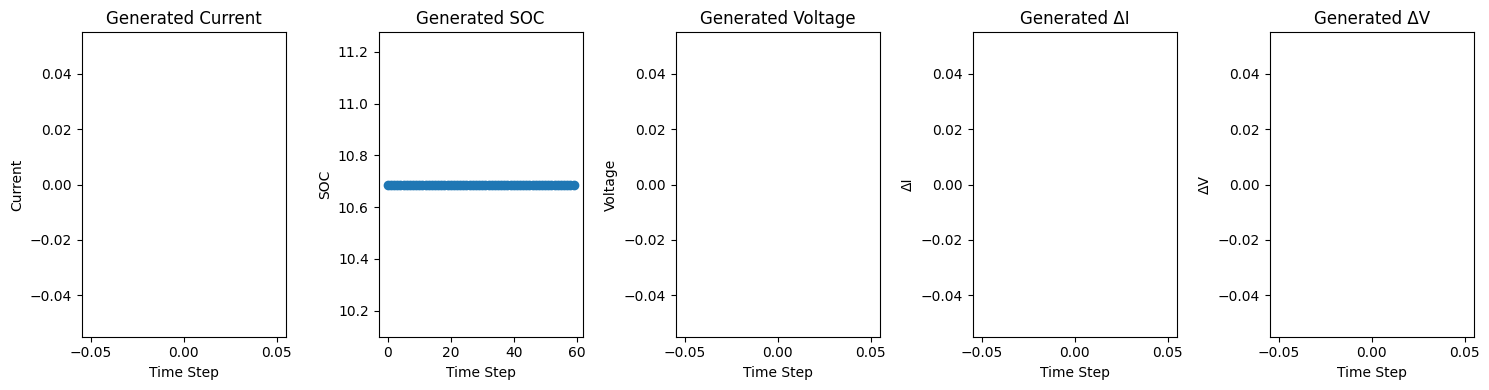

c:\Users\user\anaconda3\envs\hjjang\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\user\anaconda3\envs\hjjang\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


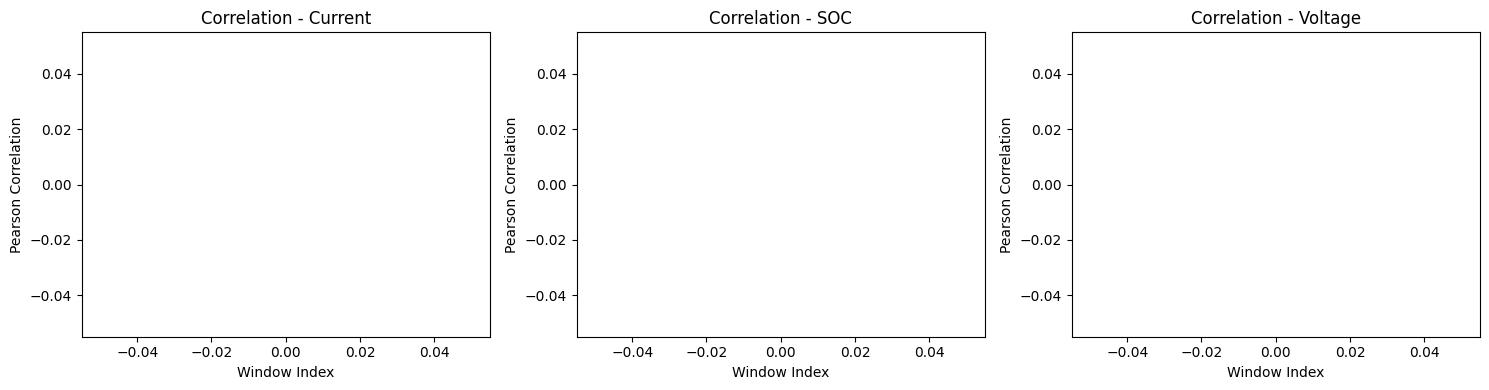

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# -------------------------------------------------------------------
# combine_output 함수 (Generator 출력: [Current, ΔI, ΔV, Voltage])
# 조건(cond_sample, SOC)은 (batch, window_size, 1) 형태이며,
# 최종 ordering: [Current, SOC, Voltage, ΔI, ΔV] (총 5채널)
# -------------------------------------------------------------------
def combine_output(dynamic, cond):
    # dynamic: (batch, window_size, 4) → [Current, ΔI, ΔV, Voltage]
    current = dynamic[..., :1]          # (batch, window_size, 1): Current
    remaining = dynamic[..., 1:]          # (batch, window_size, 3): [ΔI, ΔV, Voltage]
    cond = tf.cast(cond, dynamic.dtype)   # (batch, window_size, 1): SOC
    # 최종 생성 시퀀스: [Current, SOC, Voltage, ΔI, ΔV]
    # 주의: 생성된 remaining의 순서를 [ΔI, ΔV, Voltage]에서 [Voltage, ΔI, ΔV]로 재배열
    # 즉, remaining[..., -1:]는 Voltage, remaining[..., :2]는 [ΔI, ΔV]
    voltage = remaining[..., -1:]
    delta = remaining[..., :2]
    return tf.concat([current, cond, voltage, delta], axis=-1)

# -------------------------------------------------------------------
# 생성된 시계열 샘플 확인 (검증용)
# -------------------------------------------------------------------
# 1. 임의의 노이즈 샘플: (1, window_size, latent_dim)
noise_sample = tf.random.normal([1, window_size, latent_dim])
# 2. 조건 샘플: all_sequences의 특정 샘플에서 SOC를 추출 (shape: (1, window_size, 1))
cond_sample = get_condition(all_sequences[500:501])
# 3. 조건부 Generator 실행: Generator는 4채널 출력, ordering: [Current, ΔI, ΔV, Voltage]
latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
print("Latnent dynamic.shape :", latent_dynamic.shape)  # 예상: (1, window_size, 4)
# 4. combine_output: 최종 생성 시퀀스 구성, ordering: [Current, SOC, Voltage, ΔI, ΔV]
generated_sequence = combine_output(latent_dynamic, cond_sample)
print("Generated sequence shape:", generated_sequence.shape)  # 예상: (1, window_size, 5)

# 선택: 첫 번째 시퀀스 추출 (shape: (window_size, 5))
gen_seq = generated_sequence[0].numpy()

# 각 피처별 denormalization (피처 인덱스: 0: Current, 1: SOC, 2: Voltage, 3: ΔI, 4: ΔV)
gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)
gen_deltaV_denorm  = denormalize_feature(gen_seq, 4, data_min, data_max)

# 각 피처별 생성 데이터 시각화 (원래 스케일)
plt.figure(figsize=(15,4))
plt.subplot(1,5,1)
plt.plot(gen_current_denorm, marker='o')
plt.title('Generated Current')
plt.xlabel('Time Step')
plt.ylabel('Current')

plt.subplot(1,5,2)
plt.plot(gen_soc_denorm, marker='o')
plt.title('Generated SOC')
plt.xlabel('Time Step')
plt.ylabel('SOC')

plt.subplot(1,5,3)
plt.plot(gen_voltage_denorm, marker='o')
plt.title('Generated Voltage')
plt.xlabel('Time Step')
plt.ylabel('Voltage')

plt.subplot(1,5,4)
plt.plot(gen_deltaI_denorm, marker='o')
plt.title('Generated ΔI')
plt.xlabel('Time Step')
plt.ylabel('ΔI')

plt.subplot(1,5,5)
plt.plot(gen_deltaV_denorm, marker='o')
plt.title('Generated ΔV')
plt.xlabel('Time Step')
plt.ylabel('ΔV')

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 각 슬라이딩 윈도우별 상관계수 계산
# 전체 슬라이딩 윈도우 (all_sequences) 는 원본 5채널, 순서: [Current, SOC, Voltage, ΔI, ΔV]
# 여기서는 [Current, SOC, Voltage]에 대해 상관계수를 계산합니다.
# -------------------------------------------------------------------
n_windows = all_sequences.shape[0]
corr_current = []
corr_soc = []
corr_voltage = []

for i in range(n_windows):
    window = all_sequences[i]  # shape: (window_size, 5)
    # 각 윈도우에서 원본 피처 추출 및 denormalize
    window_current = denormalize_feature(window, 0, data_min, data_max)
    window_soc     = denormalize_feature(window, 1, data_min, data_max)
    window_voltage = denormalize_feature(window, 2, data_min, data_max)

    # Pearson 상관계수 계산 (flatten 후)
    corr_current.append(np.corrcoef(window_current.ravel(), gen_current_denorm.ravel())[0, 1])
    corr_soc.append(np.corrcoef(window_soc.ravel(), gen_soc_denorm.ravel())[0, 1])
    corr_voltage.append(np.corrcoef(window_voltage.ravel(), gen_voltage_denorm.ravel())[0, 1])

# 상관계수 결과 플롯 (피처별)
x = np.arange(n_windows)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(x, corr_current, marker='o', color='blue')
plt.title('Correlation - Current')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,2)
plt.scatter(x, corr_soc, marker='o', color='green')
plt.title('Correlation - SOC')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,3)
plt.scatter(x, corr_voltage, marker='o', color='red')
plt.title('Correlation - Voltage')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.tight_layout()
plt.show()


Sample idx 769 | Latent dynamic shape: (1, 60, 4)
Sample idx 769 | Generated sequence shape: (1, 60, 5)


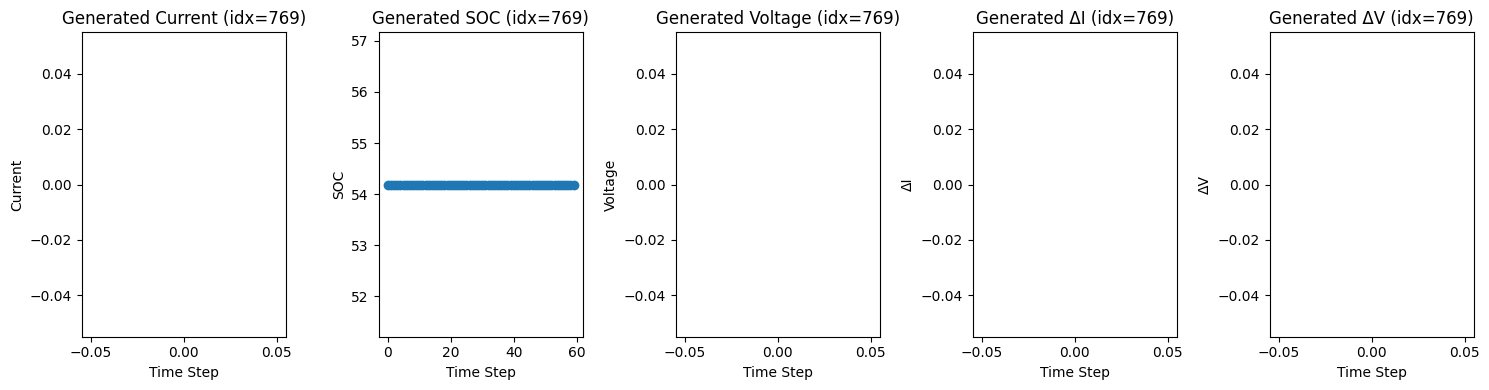

Sample idx 1782 | Latent dynamic shape: (1, 60, 4)
Sample idx 1782 | Generated sequence shape: (1, 60, 5)


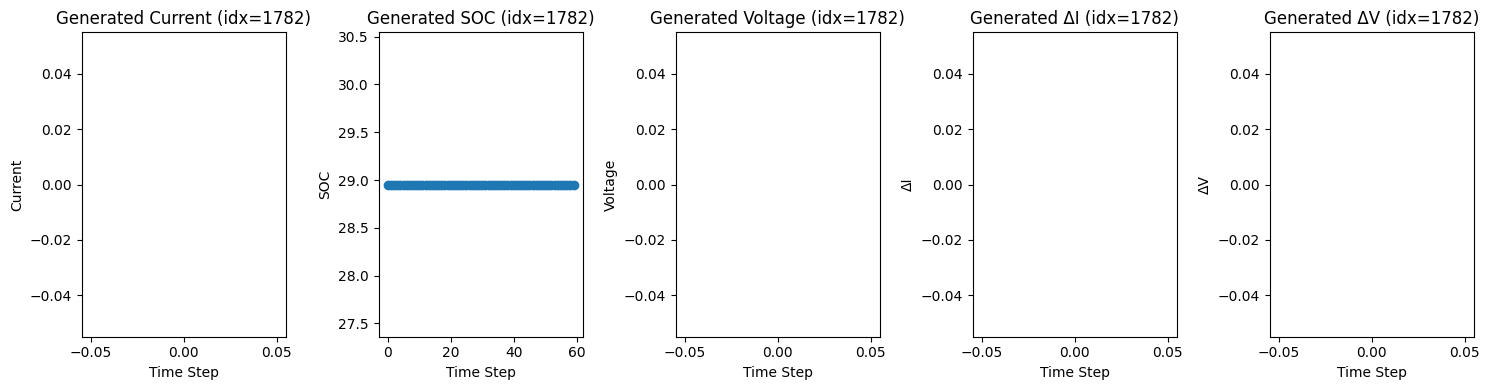

Sample idx 370 | Latent dynamic shape: (1, 60, 4)
Sample idx 370 | Generated sequence shape: (1, 60, 5)


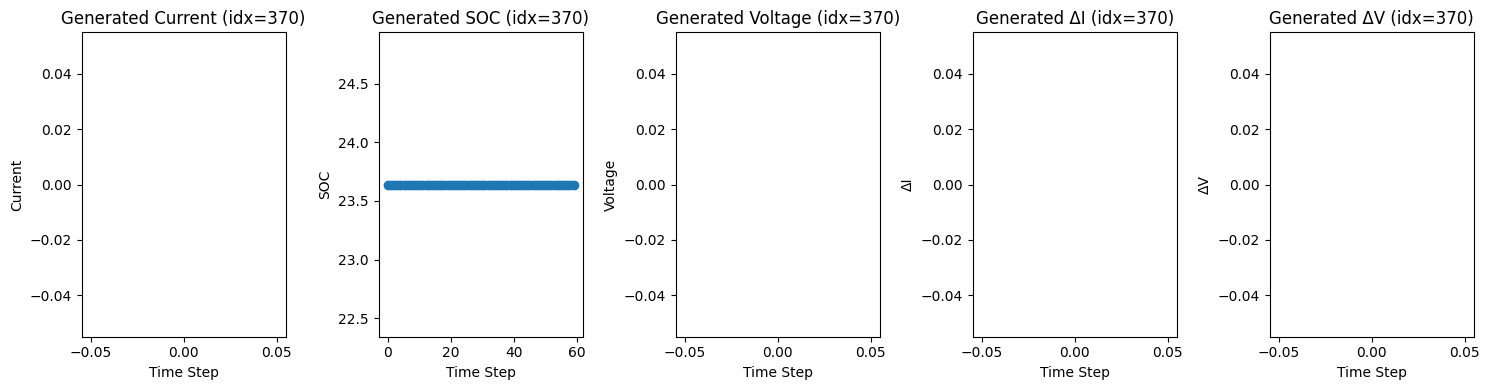

Sample idx 226 | Latent dynamic shape: (1, 60, 4)
Sample idx 226 | Generated sequence shape: (1, 60, 5)


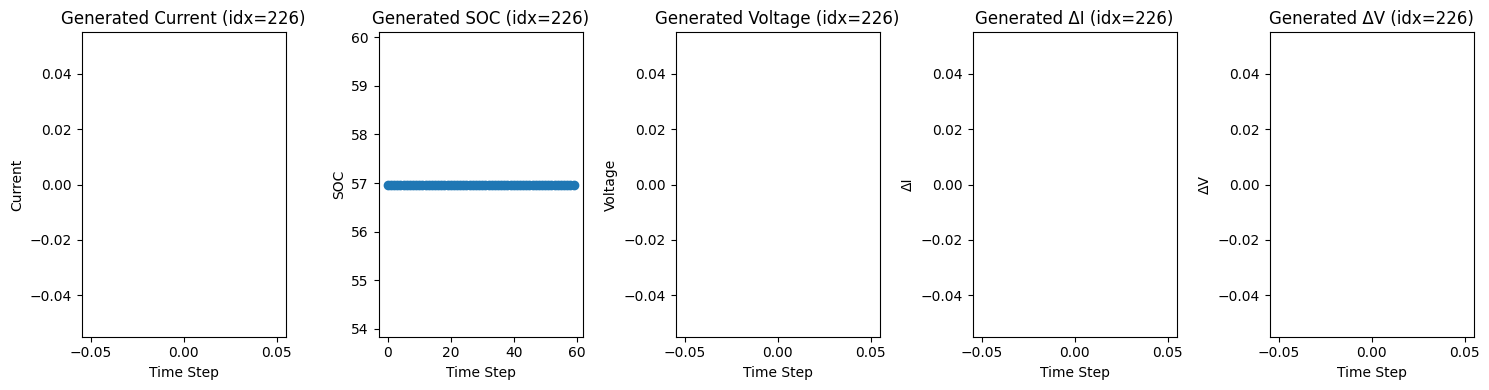

Sample idx 548 | Latent dynamic shape: (1, 60, 4)
Sample idx 548 | Generated sequence shape: (1, 60, 5)


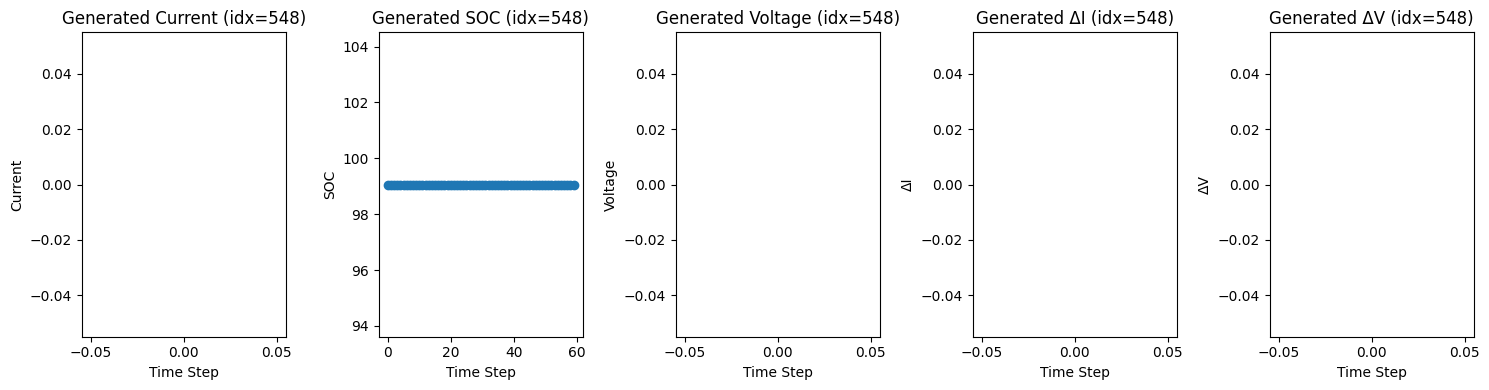

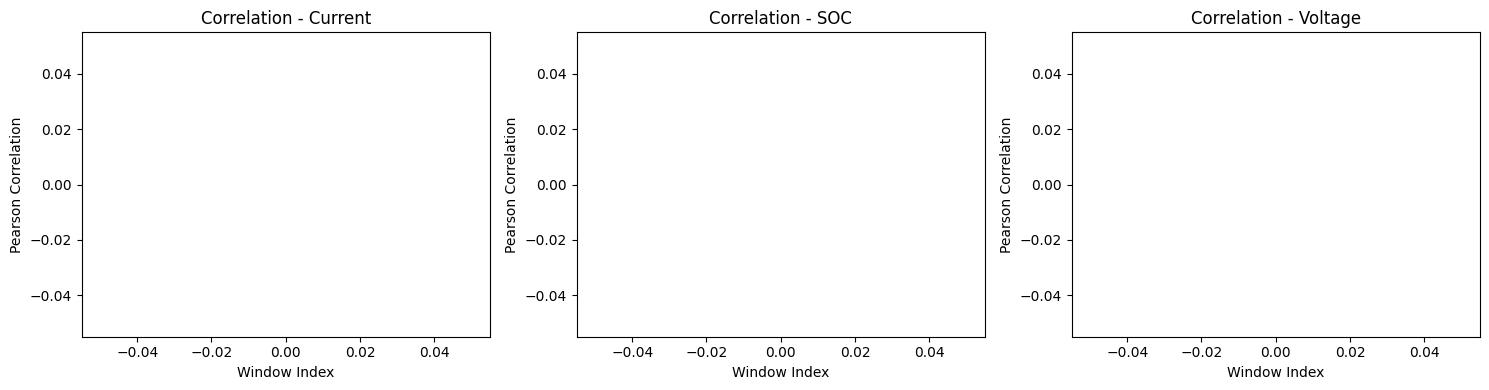

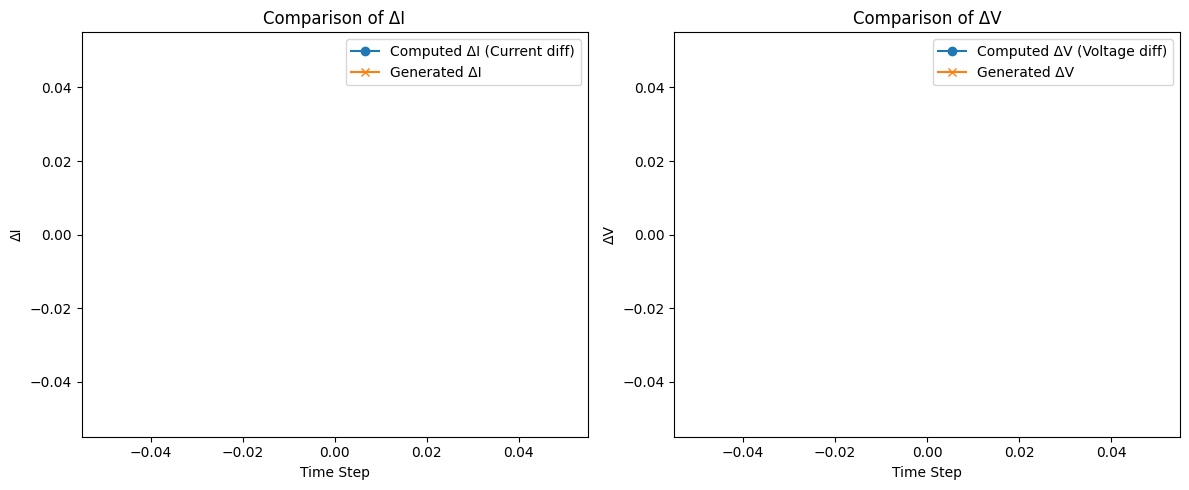

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 5개의 랜덤 샘플 인덱스 선택 (all_sequences의 shape: (num_sequences, window_size, 5))
random_indices = np.random.choice(len(all_sequences), size=5, replace=False)

for idx in random_indices:
    # 해당 샘플의 시퀀스 추출 (shape: (1, window_size, 5))
    sample_seq = all_sequences[idx:idx+1]

    # 조건(SOC) 추출: sample_seq로부터 get_condition 호출 (shape: (1, window_size, 1))
    cond_sample = get_condition(sample_seq)

    # 임의의 노이즈 샘플 생성 (shape: (1, window_size, latent_dim))
    noise_sample = tf.random.normal([1, window_size, latent_dim])

    # 조건부 Generator 실행: Generator는 4채널 출력 (ordering: [Current, ΔI, ΔV, Voltage])
    latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
    print(f"Sample idx {idx} | Latent dynamic shape: {latent_dynamic.shape}")  # 예상: (1, window_size, 4)

    # combine_output: Generator 출력에 조건(SOC)을 삽입하여 최종 생성 시퀀스 구성
    # 최종 ordering: [Current, SOC, Voltage, ΔI, ΔV]
    generated_sequence = combine_output(latent_dynamic, cond_sample)
    print(f"Sample idx {idx} | Generated sequence shape: {generated_sequence.shape}")  # 예상: (1, window_size, 5)

    # 첫 번째 시퀀스 추출 (shape: (window_size, 5))
    gen_seq = generated_sequence[0].numpy()

    # 각 피처별 denormalization
    # 인덱스: 0: Current, 1: SOC, 2: Voltage, 3: ΔI, 4: ΔV
    gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
    gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
    gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
    gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)
    gen_deltaV_denorm  = denormalize_feature(gen_seq, 4, data_min, data_max)

    # 각 피처별 생성 데이터 시각화
    plt.figure(figsize=(15,4))

    plt.subplot(1,5,1)
    plt.plot(gen_current_denorm, marker='o')
    plt.title(f'Generated Current (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Current')

    plt.subplot(1,5,2)
    plt.plot(gen_soc_denorm, marker='o')
    plt.title(f'Generated SOC (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('SOC')

    plt.subplot(1,5,3)
    plt.plot(gen_voltage_denorm, marker='o')
    plt.title(f'Generated Voltage (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Voltage')

    plt.subplot(1,5,4)
    plt.plot(gen_deltaI_denorm, marker='o')
    plt.title(f'Generated ΔI (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')

    plt.subplot(1,5,5)
    plt.plot(gen_deltaV_denorm, marker='o')
    plt.title(f'Generated ΔV (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔV')

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 슬라이딩 윈도우별 상관계수 계산 (원본 all_sequences는 (N, window_size, 5), 순서: [Current, SOC, Voltage, ΔI, ΔV])
# 여기서는 [Current, SOC, Voltage] (인덱스 0, 1, 2)에 대해 Pearson 상관계수를 계산합니다.
n_windows = all_sequences.shape[0]
corr_current = []
corr_soc = []
corr_voltage = []

# 우선, denormalize된 생성된 시퀀스의 각 피처 (위의 gen_*_denorm)와 비교할 대상은 랜덤 샘플이 아닌,
# 전체 all_sequences에서 각 윈도우에 대해 [Current, SOC, Voltage] 피처를 추출하여 denormalize한 값입니다.
for i in range(n_windows):
    window = all_sequences[i]  # (window_size, 5)
    window_current = denormalize_feature(window, 0, data_min, data_max)
    window_soc     = denormalize_feature(window, 1, data_min, data_max)
    window_voltage = denormalize_feature(window, 2, data_min, data_max)

    # 계산: gen_current_denorm, gen_soc_denorm, gen_voltage_denorm은 위에서 랜덤 샘플에서 얻은 값
    # 여기서는 각 윈도우와 그 랜덤 샘플 간의 상관계수를 계산
    corr_current.append(np.corrcoef(window_current.ravel(), gen_current_denorm.ravel())[0, 1])
    corr_soc.append(np.corrcoef(window_soc.ravel(), gen_soc_denorm.ravel())[0, 1])
    corr_voltage.append(np.corrcoef(window_voltage.ravel(), gen_voltage_denorm.ravel())[0, 1])

# 상관계수 결과 플롯 (피처별)
x = np.arange(n_windows)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(x, corr_current, marker='o', color='blue')
plt.title('Correlation - Current')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,2)
plt.scatter(x, corr_soc, marker='o', color='green')
plt.title('Correlation - SOC')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,3)
plt.scatter(x, corr_voltage, marker='o', color='red')
plt.title('Correlation - Voltage')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.tight_layout()
plt.show()

computed_deltaI = np.diff(gen_current_denorm, prepend=gen_current_denorm[0])
computed_deltaV = np.diff(gen_voltage_denorm, prepend=gen_voltage_denorm[0])

# 플롯: 왼쪽은 ΔI 비교, 오른쪽은 ΔV 비교
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(computed_deltaI, label='Computed ΔI (Current diff)', marker='o')
plt.plot(gen_deltaI_denorm, label='Generated ΔI', marker='x')
plt.title('Comparison of ΔI')
plt.xlabel('Time Step')
plt.ylabel('ΔI')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(computed_deltaV, label='Computed ΔV (Voltage diff)', marker='o')
plt.plot(gen_deltaV_denorm, label='Generated ΔV', marker='x')
plt.title('Comparison of ΔV')
plt.xlabel('Time Step')
plt.ylabel('ΔV')
plt.legend()

plt.tight_layout()
plt.show()


Sample idx 1786 | Latent dynamic shape: (1, 60, 4)
Sample idx 1786 | Generated sequence shape: (1, 60, 5)


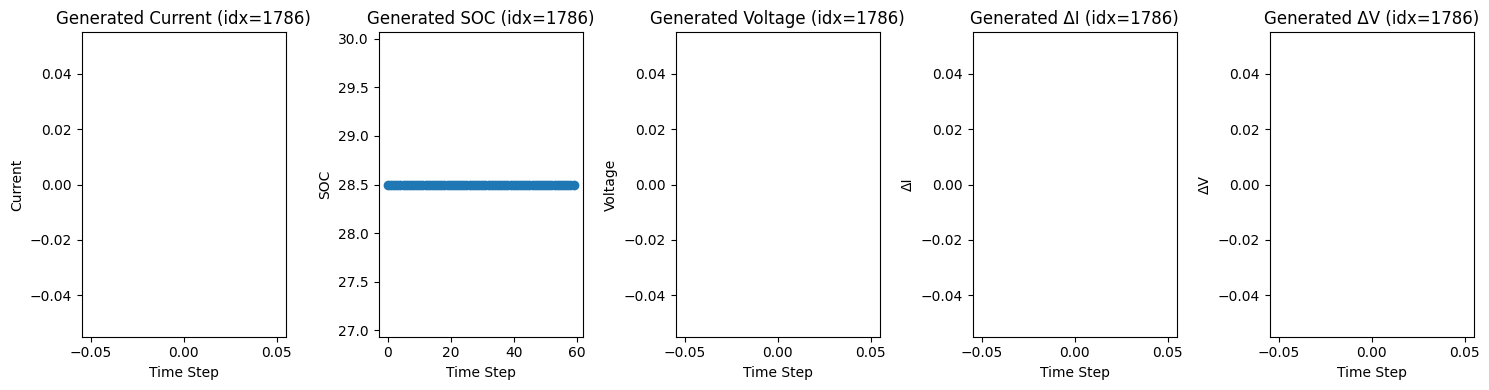

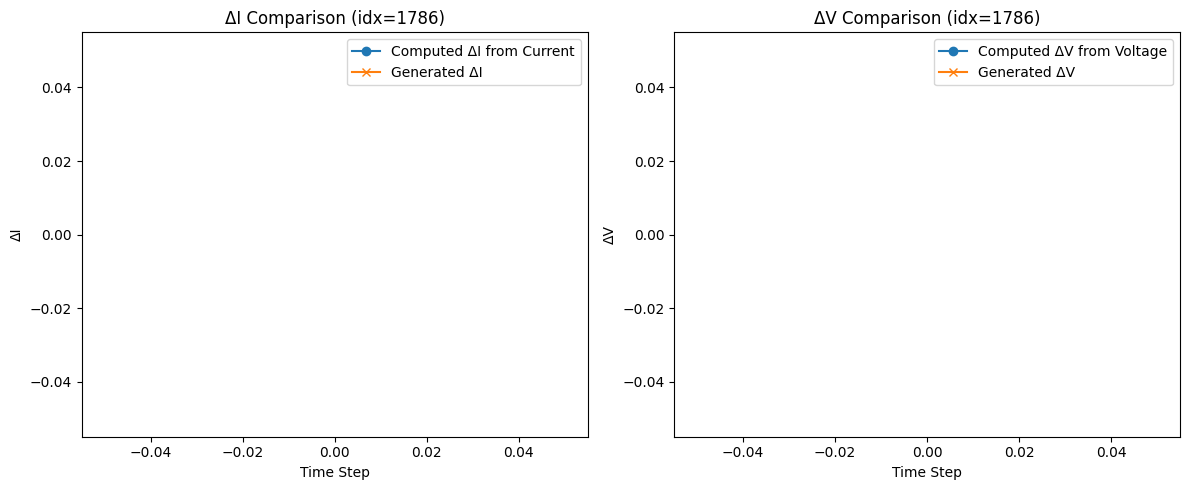

Sample idx 1378 | Latent dynamic shape: (1, 60, 4)
Sample idx 1378 | Generated sequence shape: (1, 60, 5)


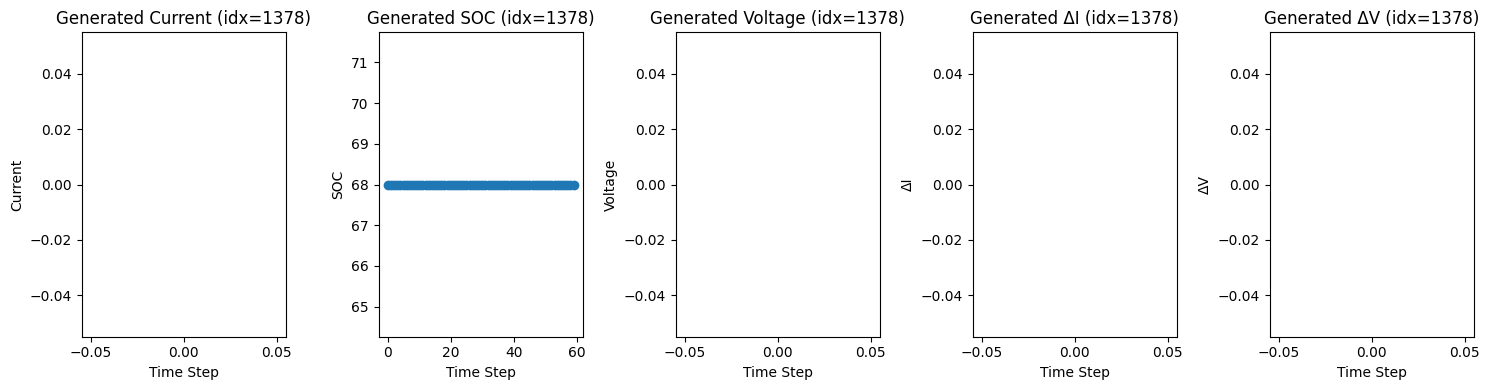

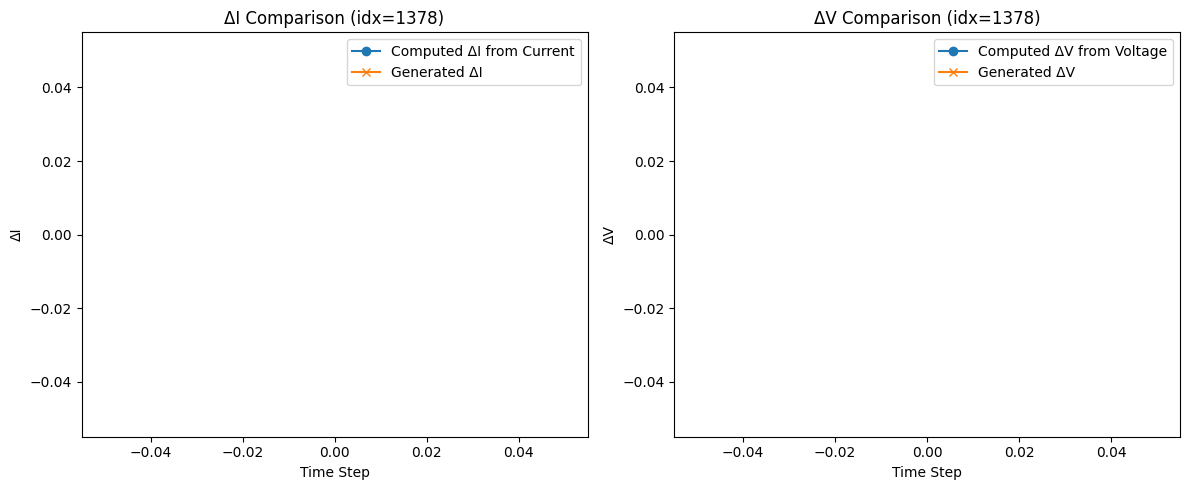

Sample idx 1760 | Latent dynamic shape: (1, 60, 4)
Sample idx 1760 | Generated sequence shape: (1, 60, 5)


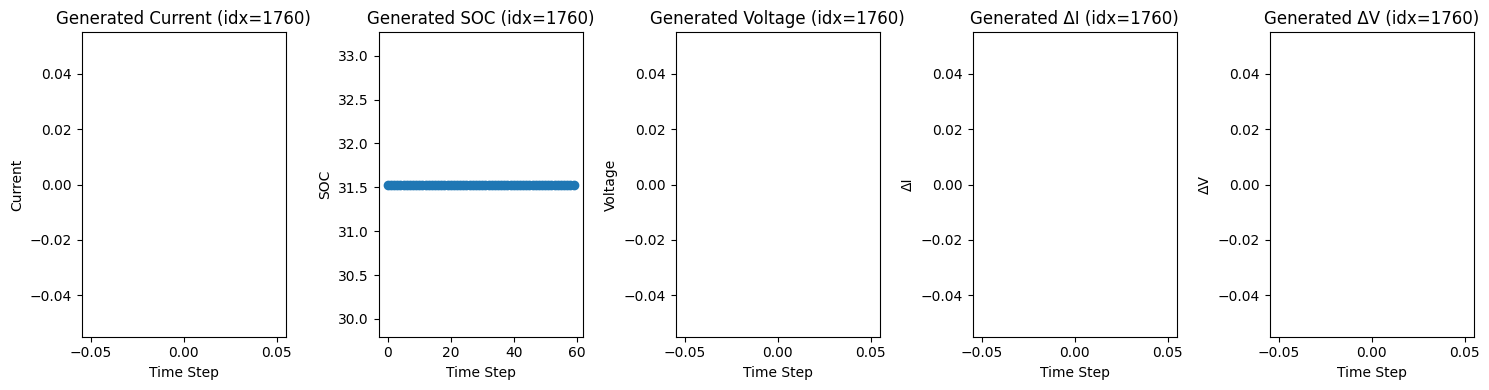

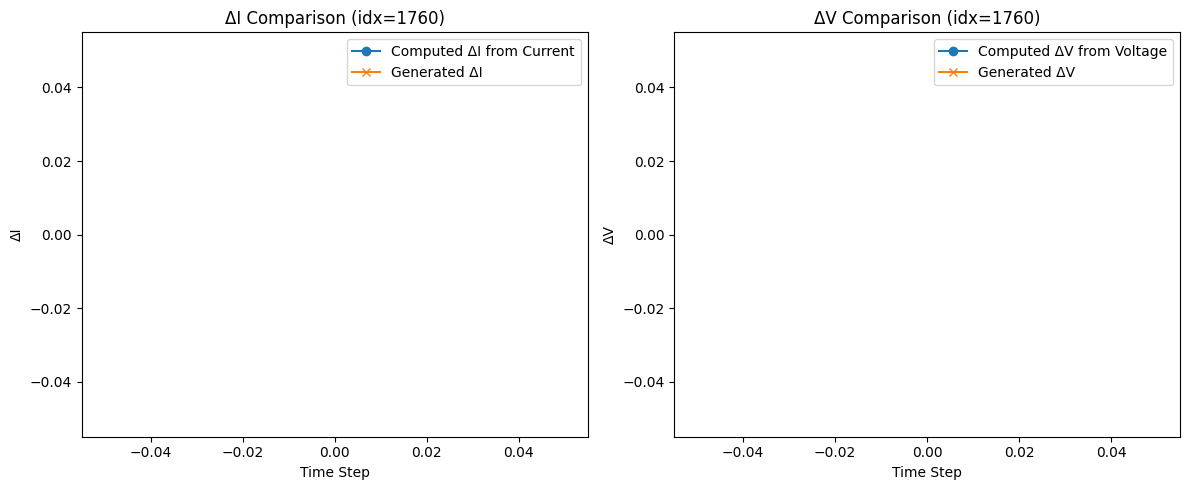

Sample idx 589 | Latent dynamic shape: (1, 60, 4)
Sample idx 589 | Generated sequence shape: (1, 60, 5)


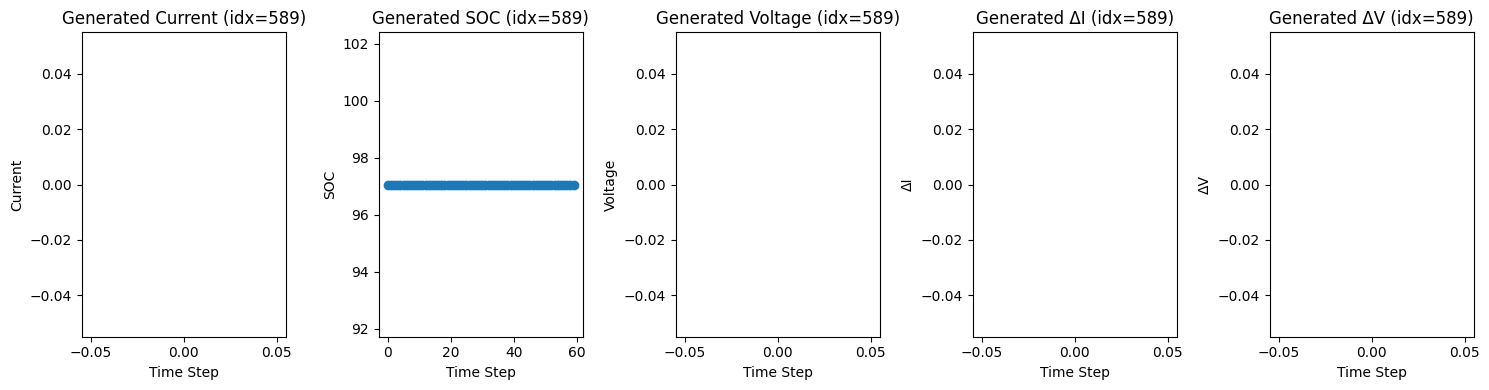

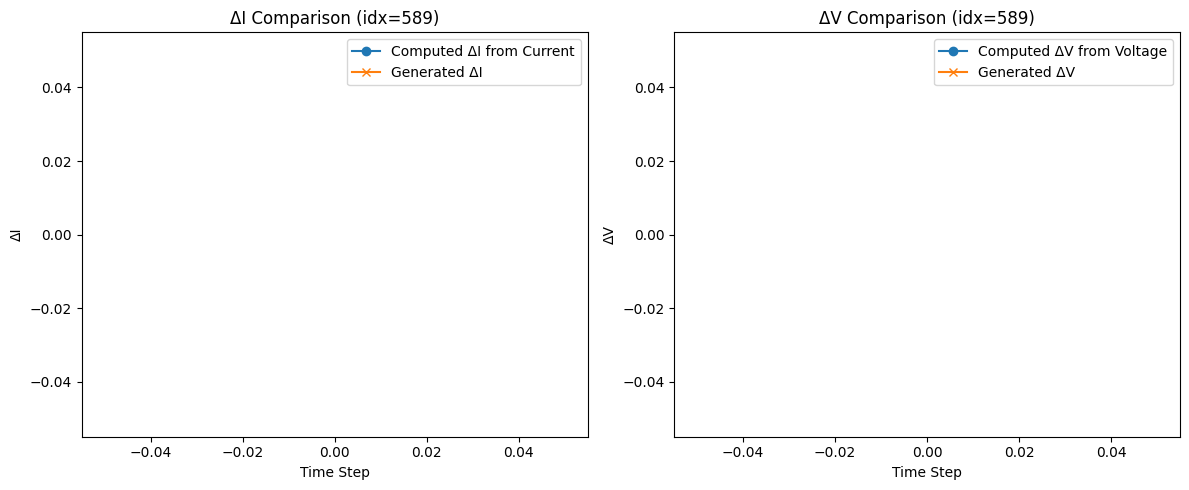

Sample idx 519 | Latent dynamic shape: (1, 60, 4)
Sample idx 519 | Generated sequence shape: (1, 60, 5)


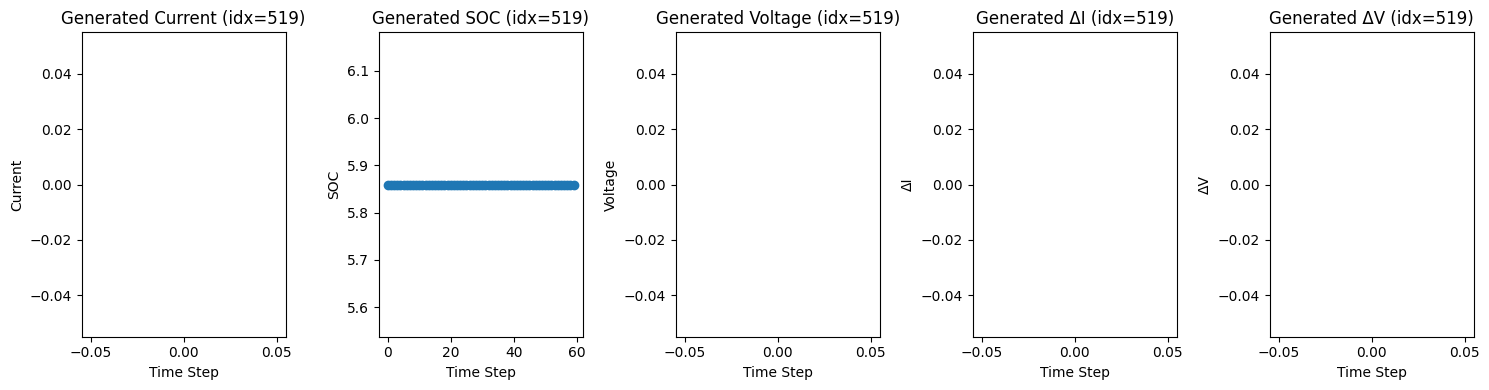

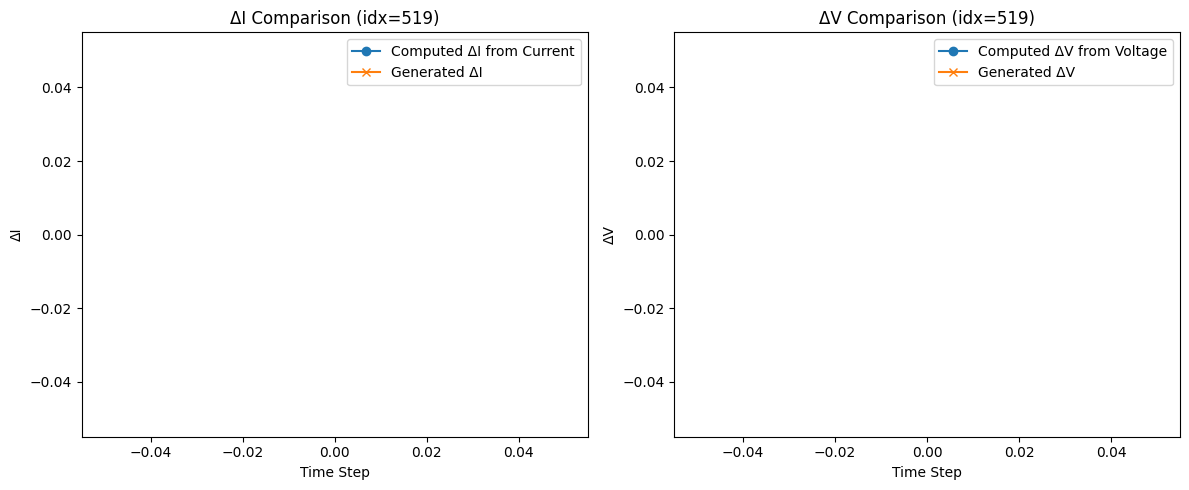

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- 최종 combine_output 함수 ---
# Generator의 원래 출력은 4채널: [Current, ΔI, ΔV, Voltage]
# 이를 재배열하여 최종 생성 시퀀스 ordering을 [Current, SOC, Voltage, ΔI, ΔV]로 만듭니다.
def combine_output(dynamic, cond):
    # dynamic: (batch, window_size, 4) → [Current, ΔI, ΔV, Voltage]
    current = dynamic[..., :1]          # [Current]
    remaining = dynamic[..., 1:]          # [ΔI, ΔV, Voltage] (원래 순서)
    # 재배열: Voltage를 맨 앞에 오게 하고, ΔI, ΔV는 뒤로 보냄
    voltage = remaining[..., -1:]
    delta = remaining[..., :2]
    cond = tf.cast(cond, dynamic.dtype)   # [SOC]
    # 최종 ordering: [Current, SOC, Voltage, ΔI, ΔV]
    return tf.concat([current, cond, voltage, delta], axis=-1)

# -------------------------------------------------------------------
# 5개의 랜덤 샘플에 대해 생성 결과 및 비교 플롯
# -------------------------------------------------------------------
num_plots = 5
random_indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

for idx in random_indices:
    # 해당 샘플 시퀀스 (shape: (1, window_size, 5))에서 조건 추출
    sample_seq = all_sequences[idx:idx+1]
    cond_sample = get_condition(sample_seq)  # (1, window_size, 1)

    # 임의의 노이즈 생성 (shape: (1, window_size, latent_dim))
    noise_sample = tf.random.normal([1, window_size, latent_dim])

    # 조건부 Generator 실행: Generator는 4채널 출력, ordering: [Current, ΔI, ΔV, Voltage]
    latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
    print(f"Sample idx {idx} | Latent dynamic shape: {latent_dynamic.shape}")  # 예상: (1, window_size, 4)

    # combine_output: 최종 생성 시퀀스 구성, ordering: [Current, SOC, Voltage, ΔI, ΔV]
    generated_sequence = combine_output(latent_dynamic, cond_sample)
    print(f"Sample idx {idx} | Generated sequence shape: {generated_sequence.shape}")  # 예상: (1, window_size, 5)

    # 첫 번째 시퀀스 추출 (shape: (window_size, 5))
    gen_seq = generated_sequence[0].numpy()

    # 각 피처별 denormalization (data_min, data_max는 원래 [Current, SOC, Voltage, ΔI, ΔV] 순서)
    gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
    gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
    gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
    gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)
    gen_deltaV_denorm  = denormalize_feature(gen_seq, 4, data_min, data_max)

    # 생성된 Current, SOC, Voltage, ΔI, ΔV 플롯
    plt.figure(figsize=(15,4))
    plt.subplot(1,5,1)
    plt.plot(gen_current_denorm, marker='o')
    plt.title(f'Generated Current (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Current')

    plt.subplot(1,5,2)
    plt.plot(gen_soc_denorm, marker='o')
    plt.title(f'Generated SOC (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('SOC')

    plt.subplot(1,5,3)
    plt.plot(gen_voltage_denorm, marker='o')
    plt.title(f'Generated Voltage (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Voltage')

    plt.subplot(1,5,4)
    plt.plot(gen_deltaI_denorm, marker='o')
    plt.title(f'Generated ΔI (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')

    plt.subplot(1,5,5)
    plt.plot(gen_deltaV_denorm, marker='o')
    plt.title(f'Generated ΔV (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔV')

    plt.tight_layout()
    plt.show()

    # 추가: Generated Current와 Voltage의 시간차분을 계산하여 Δ 비교
    computed_deltaI = np.diff(gen_current_denorm, prepend=gen_current_denorm[0])
    computed_deltaV = np.diff(gen_voltage_denorm, prepend=gen_voltage_denorm[0])

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(computed_deltaI, marker='o', label='Computed ΔI from Current')
    plt.plot(gen_deltaI_denorm, marker='x', label='Generated ΔI')
    plt.title(f'ΔI Comparison (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(computed_deltaV, marker='o', label='Computed ΔV from Voltage')
    plt.plot(gen_deltaV_denorm, marker='x', label='Generated ΔV')
    plt.title(f'ΔV Comparison (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔV')
    plt.legend()

    plt.tight_layout()
    plt.show()


[Sample idx=816] latent_dynamic.shape = (1, 60, 4)
[Sample idx=816] generated_sequence.shape = (1, 60, 5)
[Sample idx=816] Teacher(1D-CNN) vs. GAN Voltage: MSE=nan, Corr=nan
[Sample idx=816] Teacher(LSTM)   vs. GAN Voltage: MSE=nan, Corr=nan


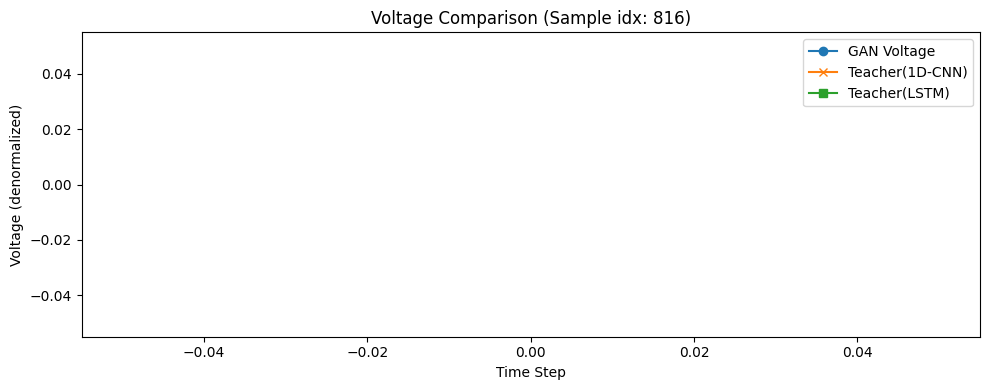

[Sample idx=782] latent_dynamic.shape = (1, 60, 4)
[Sample idx=782] generated_sequence.shape = (1, 60, 5)
[Sample idx=782] Teacher(1D-CNN) vs. GAN Voltage: MSE=nan, Corr=nan
[Sample idx=782] Teacher(LSTM)   vs. GAN Voltage: MSE=nan, Corr=nan


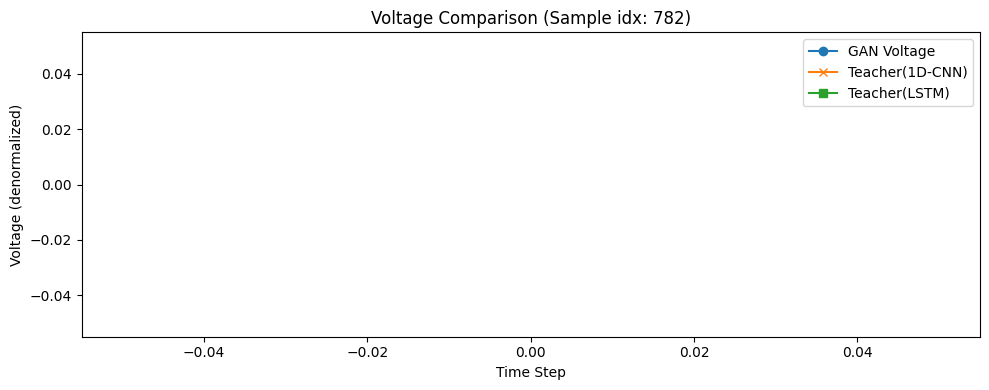

[Sample idx=1712] latent_dynamic.shape = (1, 60, 4)
[Sample idx=1712] generated_sequence.shape = (1, 60, 5)
[Sample idx=1712] Teacher(1D-CNN) vs. GAN Voltage: MSE=nan, Corr=nan
[Sample idx=1712] Teacher(LSTM)   vs. GAN Voltage: MSE=nan, Corr=nan


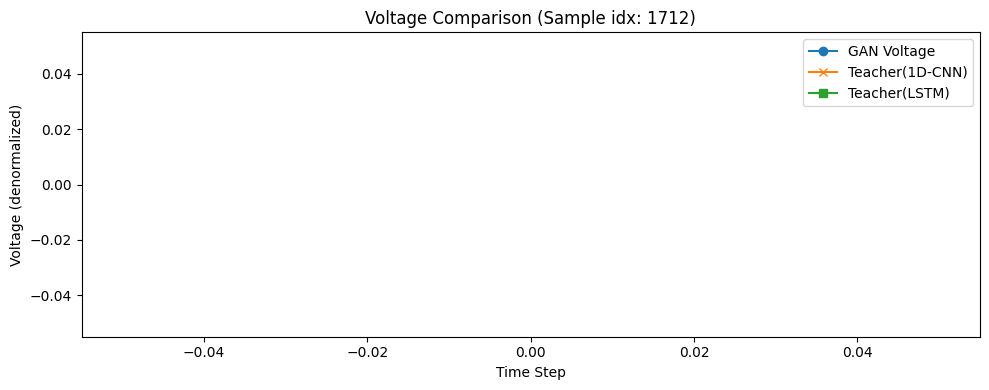

[Sample idx=1253] latent_dynamic.shape = (1, 60, 4)
[Sample idx=1253] generated_sequence.shape = (1, 60, 5)
[Sample idx=1253] Teacher(1D-CNN) vs. GAN Voltage: MSE=nan, Corr=nan
[Sample idx=1253] Teacher(LSTM)   vs. GAN Voltage: MSE=nan, Corr=nan


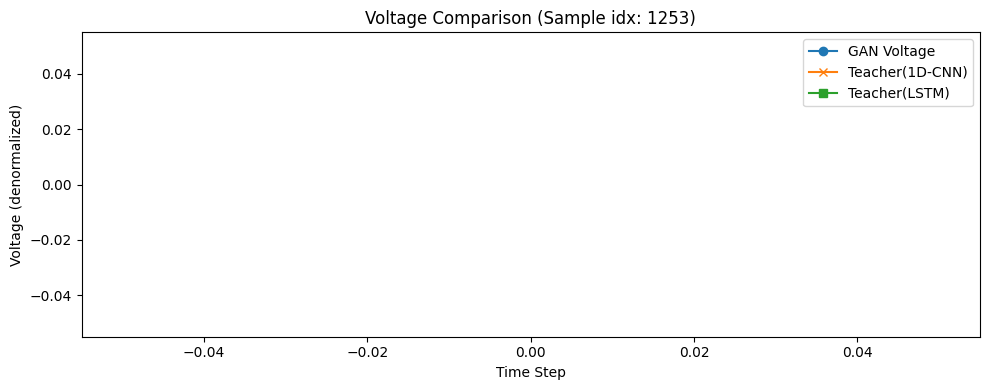

[Sample idx=987] latent_dynamic.shape = (1, 60, 4)
[Sample idx=987] generated_sequence.shape = (1, 60, 5)
[Sample idx=987] Teacher(1D-CNN) vs. GAN Voltage: MSE=nan, Corr=nan
[Sample idx=987] Teacher(LSTM)   vs. GAN Voltage: MSE=nan, Corr=nan


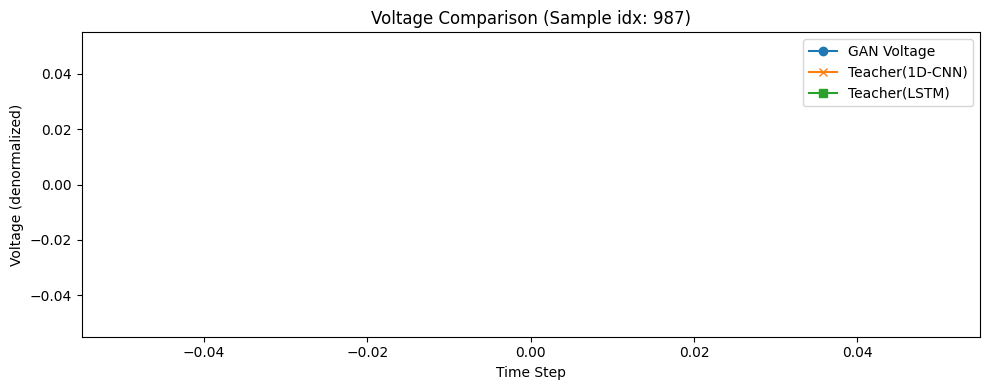

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 가정:
# - all_sequences: (N, window_size, 5)
# - get_condition: SOC 추출 함수
# - generator_cond: Generator 모델 (4채널 출력: [Current, ΔI, ΔV, Voltage])
# - combine_output: 최종 5채널 ([Current, SOC, Voltage, ΔI, ΔV])를 만드는 함수
# - teacher_model, teacher_model_2: Teacher 모델 (freeze 상태)
# - data_min, data_max: 각 채널([Current, SOC, Voltage, ΔI, ΔV])의 최소·최대값
# - latent_dim, window_size: 이미 정의됨

def denorm_vector(vec, feature_index, data_min, data_max):
    # vec: 1D (window_size,)
    # feature_index: 채널 인덱스 (여기서는 2: Voltage)
    return vec * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

num_plots = 5
indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

voltage_model = teacher_model       # 1D-CNN Teacher
voltage_model_2 = teacher_model_2   # LSTM Teacher

for idx in indices:
    # (1) 해당 샘플 시퀀스(1, window_size, 5)에서 SOC 추출
    sample_seq = all_sequences[idx:idx+1]  # shape: (1, window_size, 5)
    cond_sample = get_condition(sample_seq)  # (1, window_size, 1)

    # (2) 임의 노이즈 생성 (1, window_size, latent_dim)
    noise_sample = tf.random.normal([1, window_size, latent_dim])

    # (3) Generator 실행: 4채널 [Current, ΔI, ΔV, Voltage]
    latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
    print(f"[Sample idx={idx}] latent_dynamic.shape =", latent_dynamic.shape)

    # (4) combine_output → 최종 5채널 [Current, SOC, Voltage, ΔI, ΔV]
    generated_sequence = combine_output(latent_dynamic, cond_sample)
    print(f"[Sample idx={idx}] generated_sequence.shape =", generated_sequence.shape)

    # (5) Teacher 모델 입력: 채널 인덱스 [0,1,3,4] → [Current, SOC, ΔI, ΔV]
    # shape: (1, window_size, 4)
    teacher_input = tf.gather(generated_sequence, indices=[0,1,3,4], axis=-1)

    # (6) Teacher 모델 예측
    # 1D-CNN
    teacher_pred1 = voltage_model(teacher_input, training=False)   # (1, window_size, 1)
    teacher_pred1 = tf.squeeze(teacher_pred1, axis=-1).numpy()[0]  # (window_size,)
    # LSTM
    teacher_pred2 = voltage_model_2(teacher_input, training=False)  # (1, window_size, 1)
    teacher_pred2 = tf.squeeze(teacher_pred2, axis=-1).numpy()[0]   # (window_size,)

    # (7) GAN이 생성한 전압: 채널 2 (shape: (window_size,))
    gan_voltage = generated_sequence[0, :, 2].numpy()

    # (8) Denormalize (Voltage → feature_index=2)
    gan_voltage_denorm = denorm_vector(gan_voltage, 2, data_min, data_max)
    teacher_voltage_denorm1 = denorm_vector(teacher_pred1, 2, data_min, data_max)
    teacher_voltage_denorm2 = denorm_vector(teacher_pred2, 2, data_min, data_max)

    # (9) 평가 (MSE, Corr)
    mse_teacher1 = np.mean((gan_voltage_denorm - teacher_voltage_denorm1)**2)
    corr_teacher1 = np.corrcoef(gan_voltage_denorm, teacher_voltage_denorm1)[0, 1]
    mse_teacher2 = np.mean((gan_voltage_denorm - teacher_voltage_denorm2)**2)
    corr_teacher2 = np.corrcoef(gan_voltage_denorm, teacher_voltage_denorm2)[0, 1]

    print(f"[Sample idx={idx}] Teacher(1D-CNN) vs. GAN Voltage: MSE={mse_teacher1:.4f}, Corr={corr_teacher1:.4f}")
    print(f"[Sample idx={idx}] Teacher(LSTM)   vs. GAN Voltage: MSE={mse_teacher2:.4f}, Corr={corr_teacher2:.4f}")

    # (10) 시각화
    plt.figure(figsize=(10,4))
    plt.plot(gan_voltage_denorm, marker='o', label='GAN Voltage')
    plt.plot(teacher_voltage_denorm1, marker='x', label='Teacher(1D-CNN)')
    plt.plot(teacher_voltage_denorm2, marker='s', label='Teacher(LSTM)')
    plt.title(f"Voltage Comparison (Sample idx: {idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (denormalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()


Train data head:
   Current    SOC  Voltage   △I   △V
0    -13.7  100.0    746.3  0.0  0.0
1    -14.0  100.0    746.4 -0.3  0.1
2    -13.8  100.0    746.2  0.2 -0.2
3    -14.1  100.0    746.3 -0.3  0.1
4    -13.9  100.0    746.1  0.2 -0.2
Scaled Train data shape: (5807, 5)
all_sequences_verify shape: (1512, 60, 5)
Generator model loaded.
Total windows: 1512
Top 5 window indices with highest correlation: [1511  507  498  499  500]

=== Window idx: 1511 ===
[Normalized] Current Corr: nan, Voltage Corr: nan
[Denormalized] Current Corr: nan, Voltage Corr: nan
Original SOC (norm): [0.00510725 0.00510725 0.00510725 0.00510725 0.00510725 0.00510725
 0.0040858  0.0040858  0.0040858  0.0040858  0.0040858  0.0040858
 0.0040858  0.0040858  0.0040858  0.0040858  0.0040858  0.0040858
 0.0040858  0.0040858  0.0040858  0.0040858  0.0040858  0.0040858
 0.0040858  0.0040858  0.0040858  0.0040858  0.0040858  0.0040858
 0.0040858  0.0040858  0.0040858  0.0040858  0.0040858  0.0040858
 0.0040858  0.004085

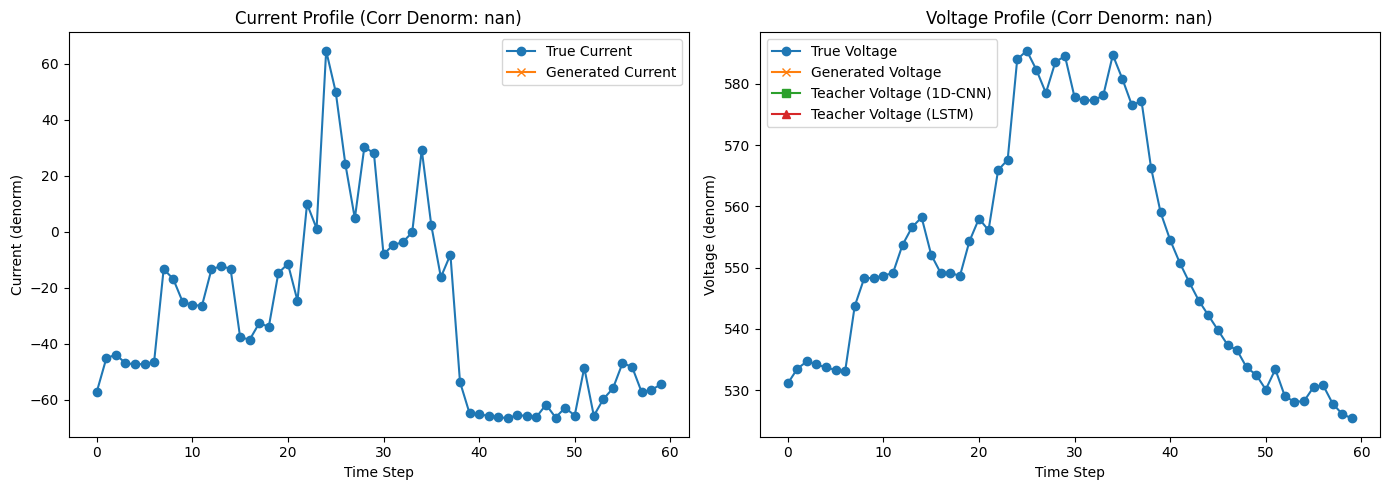


=== Window idx: 507 ===
[Normalized] Current Corr: nan, Voltage Corr: nan
[Denormalized] Current Corr: nan, Voltage Corr: nan
Original SOC (norm): [0.07252298 0.07252298 0.07252298 0.07150153 0.07150153 0.07150153
 0.07048008 0.07048008 0.07048008 0.07048008 0.06945863 0.06945863
 0.06945863 0.06843718 0.06843718 0.06843718 0.06741573 0.06741573
 0.06741573 0.06741573 0.06639428 0.06639428 0.06639428 0.06537283
 0.06537283 0.06537283 0.06537283 0.06435138 0.06435138 0.06435138
 0.06435138 0.06332993 0.06332993 0.06332993 0.06230848 0.06230848
 0.06230848 0.06230848 0.06128703 0.06128703 0.06128703 0.06128703
 0.06026558 0.06026558 0.06026558 0.05924413 0.05924413 0.05924413
 0.05924413 0.05924413 0.05924413 0.05924413 0.05924413 0.05924413
 0.05924413 0.05822268 0.05822268 0.05822268 0.05822268 0.05720123]
Original SOC (denorm): [9.2      9.2      9.2      9.1      9.1      9.1      9.       9.
 9.       9.       8.9      8.9      8.9      8.8      8.8      8.8
 8.7      8.7      8.7 

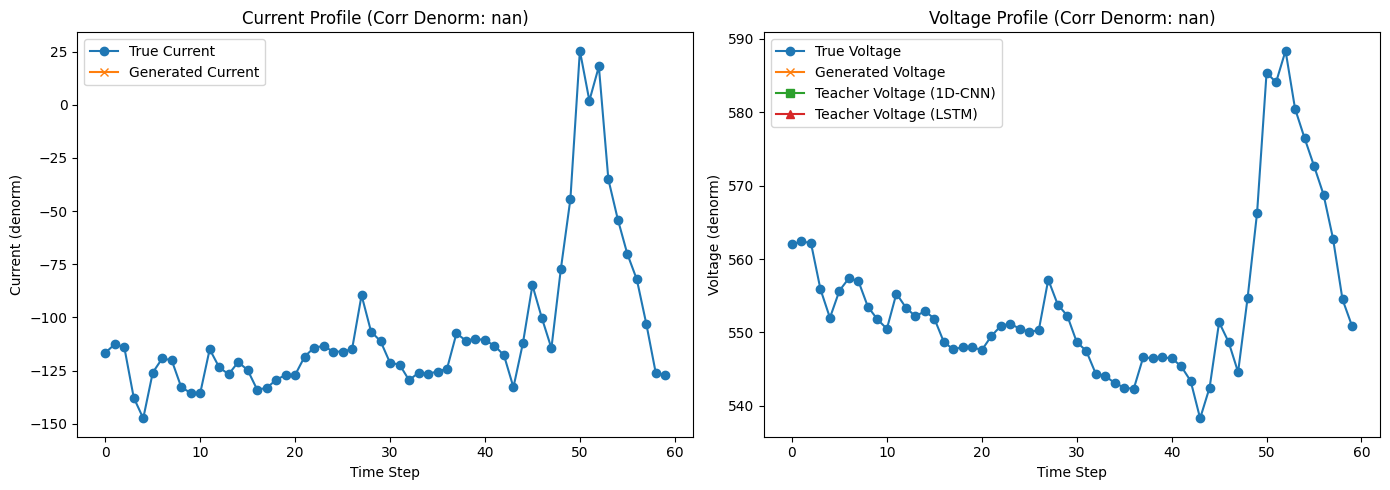


=== Window idx: 498 ===
[Normalized] Current Corr: nan, Voltage Corr: nan
[Denormalized] Current Corr: nan, Voltage Corr: nan
Original SOC (norm): [0.10623085 0.1052094  0.1052094  0.1052094  0.10418795 0.10418795
 0.10418795 0.1031665  0.1031665  0.1031665  0.1031665  0.1031665
 0.10214505 0.10214505 0.10112359 0.10112359 0.10010214 0.10010214
 0.0990807  0.0990807  0.09805924 0.09805924 0.09805924 0.09703779
 0.09703779 0.09703779 0.09601634 0.09601634 0.09601634 0.0949949
 0.0949949  0.09397344 0.09397344 0.09397344 0.09295199 0.09295199
 0.09295199 0.09295199 0.09193054 0.09193054 0.09193054 0.09193054
 0.09090909 0.09090909 0.08988764 0.08988764 0.08988764 0.08886619
 0.08886619 0.08886619 0.08886619 0.08784474 0.08784474 0.08784474
 0.08682329 0.08682329 0.08580184 0.08580184 0.08580184 0.08478039]
Original SOC (denorm): [12.5      12.4      12.4      12.4      12.300001 12.300001 12.300001
 12.200001 12.200001 12.200001 12.200001 12.200001 12.1      12.1
 12.       12.       11

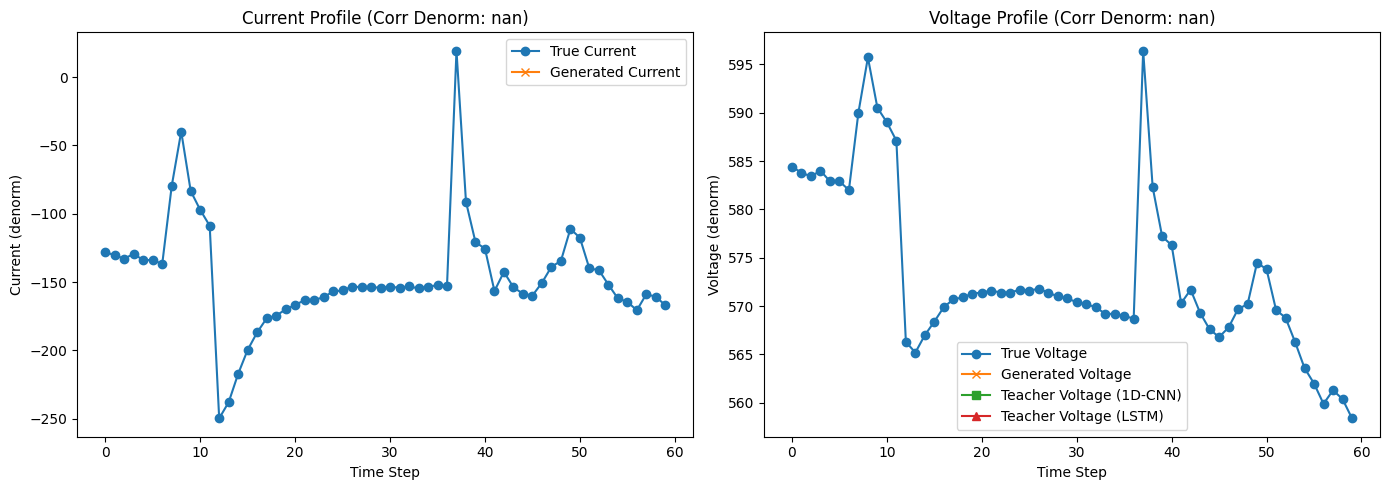


=== Window idx: 499 ===
[Normalized] Current Corr: nan, Voltage Corr: nan
[Denormalized] Current Corr: nan, Voltage Corr: nan
Original SOC (norm): [0.1031665  0.10214505 0.10214505 0.10112359 0.10112359 0.10010214
 0.10010214 0.0990807  0.0990807  0.09805924 0.09805924 0.09805924
 0.09703779 0.09703779 0.09703779 0.09601634 0.09601634 0.09601634
 0.0949949  0.0949949  0.09397344 0.09397344 0.09397344 0.09295199
 0.09295199 0.09295199 0.09295199 0.09193054 0.09193054 0.09193054
 0.09193054 0.09090909 0.09090909 0.08988764 0.08988764 0.08988764
 0.08886619 0.08886619 0.08886619 0.08886619 0.08784474 0.08784474
 0.08784474 0.08682329 0.08682329 0.08580184 0.08580184 0.08580184
 0.08478039 0.08478039 0.08375894 0.08375894 0.08375894 0.08273749
 0.08273749 0.08273749 0.08171604 0.08171604 0.08171604 0.08069459]
Original SOC (denorm): [12.200001 12.1      12.1      12.       12.       11.9      11.9
 11.800001 11.800001 11.700001 11.700001 11.700001 11.6      11.6
 11.6      11.5      11.5 

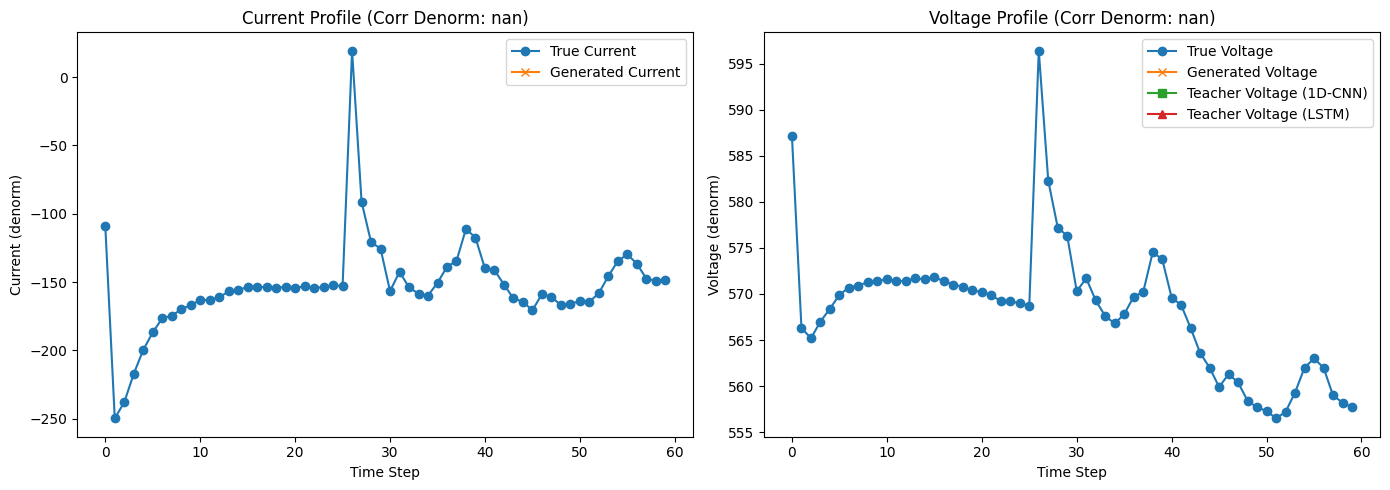


=== Window idx: 500 ===
[Normalized] Current Corr: nan, Voltage Corr: nan
[Denormalized] Current Corr: nan, Voltage Corr: nan
Original SOC (norm): [0.09805924 0.09703779 0.09703779 0.09703779 0.09601634 0.09601634
 0.09601634 0.0949949  0.0949949  0.09397344 0.09397344 0.09397344
 0.09295199 0.09295199 0.09295199 0.09295199 0.09193054 0.09193054
 0.09193054 0.09193054 0.09090909 0.09090909 0.08988764 0.08988764
 0.08988764 0.08886619 0.08886619 0.08886619 0.08886619 0.08784474
 0.08784474 0.08784474 0.08682329 0.08682329 0.08580184 0.08580184
 0.08580184 0.08478039 0.08478039 0.08375894 0.08375894 0.08375894
 0.08273749 0.08273749 0.08273749 0.08171604 0.08171604 0.08171604
 0.08069459 0.08069459 0.08069459 0.08069459 0.08069459 0.08069459
 0.07967313 0.07967313 0.07967313 0.07865169 0.07865169 0.07763024]
Original SOC (denorm): [11.700001 11.6      11.6      11.6      11.5      11.5      11.5
 11.4      11.4      11.299999 11.299999 11.299999 11.200001 11.200001
 11.200001 11.200001 

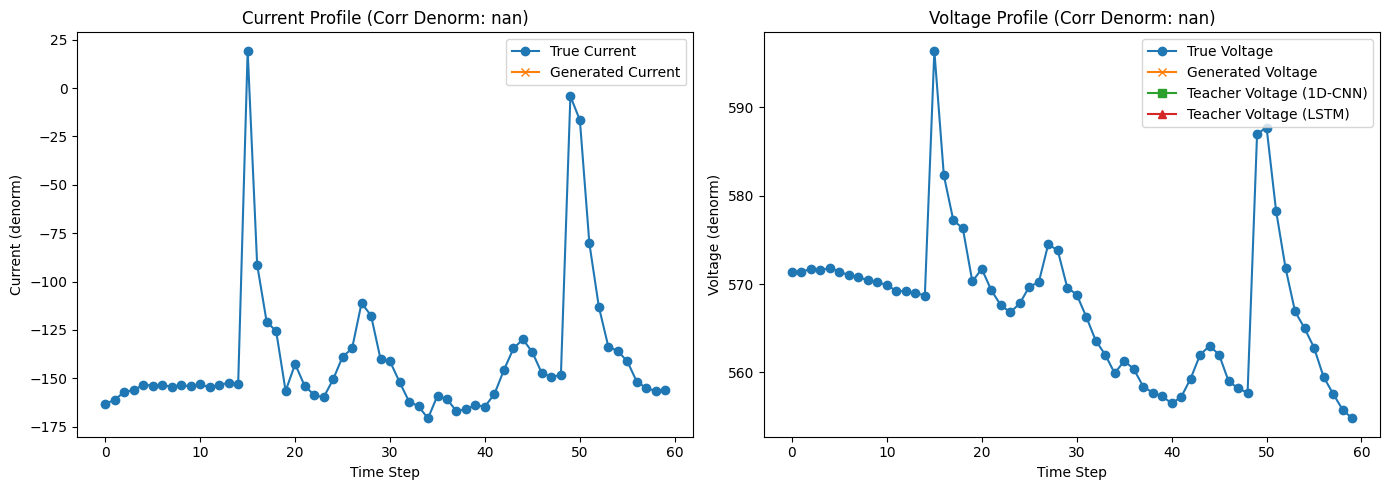

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, LeakyReLU, ConvLSTM2D, Conv2D, Flatten, Concatenate, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ------------------------------
# 1. 데이터 로드 및 전처리 (이전 코드 동일)
# ------------------------------
def MinMaxScaler(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min + 1e-7)

def denormalize_feature(vec, feature_index, data_min, data_max):
    """정규화된 1D 벡터 vec를, 해당 feature_index의 data_min, data_max를 사용해 원래 스케일로 복원"""
    return vec * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

train_path = r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt"
test_path  = r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt"

train_data = pd.read_csv(train_path, delimiter=",")
test_data  = pd.read_csv(test_path, delimiter=",")

train_data = train_data.iloc[:, [0, 2, 4]]
test_data  = test_data.iloc[:, [0, 2, 4]]
cols = ['Current', 'SOC', 'Voltage']
train_data.columns = cols
test_data.columns = cols

train_data['△I'] = train_data['Current'].diff().fillna(0)
train_data['△V'] = train_data['Voltage'].diff().fillna(0)
test_data['△I'] = test_data['Current'].diff().fillna(0)
test_data['△V'] = test_data['Voltage'].diff().fillna(0)

print("Train data head:")
print(train_data.head())

combined_data = pd.concat([train_data, test_data], ignore_index=True)
data_min = combined_data.min().values
data_max = combined_data.max().values
train_scaled = MinMaxScaler(train_data.values, data_min, data_max)
test_scaled  = MinMaxScaler(test_data.values, data_min, data_max)
print("Scaled Train data shape:", train_scaled.shape)

# ------------------------------
# 2. 슬라이딩 윈도우 시퀀스 생성 및 all_sequences_verify 생성
# ------------------------------
def create_sequences_non_overlapping(data, window_size, overlap):
    stride = int(window_size * (1 - overlap))
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

all_data_verify = np.concatenate([train_scaled, test_scaled], axis=0)
all_sequences_verify = create_sequences_non_overlapping(all_data_verify, window_size, overlap_factor)
print("all_sequences_verify shape:", all_sequences_verify.shape)  # (num_windows, window_size, 5)

# ------------------------------
# 3. Generator 관련 함수 및 모델 불러오기
# ------------------------------
def get_condition(real_series):
    """마지막 time step의 SOC(채널 1)를 추출, window_size번 복제 -> (batch, window_size, 1)"""
    soc = real_series[:, -1, 1]  # (batch,)
    soc = tf.expand_dims(soc, axis=1)  # (batch, 1)
    soc = tf.tile(soc, [1, window_size])  # (batch, window_size)
    soc = tf.expand_dims(soc, axis=-1)  # (batch, window_size, 1)
    return tf.cast(soc, tf.float32)

generator_cond = tf.keras.models.load_model("250309_gan_generator.h5")
print("Generator model loaded.")

num_windows = all_sequences_verify.shape[0]
print("Total windows:", num_windows)

# ------------------------------
# 4. 배치 처리로 Generator 실행 (정규화 상태 Corr 계산)
# ------------------------------
all_sequences_verify = all_sequences_verify.astype(np.float32)
cond_all = get_condition(all_sequences_verify)  # shape: (num_windows, window_size, 1)
noise_fixed = tf.random.normal([1, window_size, 50], dtype=tf.float32)  # latent_dim=50
noise_all = tf.tile(noise_fixed, [num_windows, 1, 1])  # (num_windows, window_size, latent_dim)

# Generator 전체 배치 실행
generated_all = generator_cond([noise_all, cond_all], training=False)  # (num_windows, window_size, 4)
true_current_all = all_sequences_verify[..., 0]  # (num_windows, window_size)
gen_current_all = generated_all[..., 0].numpy()  # (num_windows, window_size)

# 정규화 상태의 Current 상관계수 계산
corrs = np.zeros(num_windows)
for i in range(num_windows):
    true_current = true_current_all[i]
    gen_current  = gen_current_all[i]
    corrs[i] = np.corrcoef(true_current, gen_current)[0, 1]

top5_indices = np.argsort(corrs)[-5:][::-1]
print("Top 5 window indices with highest correlation:", top5_indices)

# ------------------------------
# 5. 상위 5개 윈도우에 대해 Denormalized Corr 및 Teacher 모델 결과까지 플롯
# ------------------------------
for idx in top5_indices:
    window = all_sequences_verify[idx:idx+1]  # (1, window_size, 5)
    true_current_norm = window[0, :, 0]
    true_soc_norm     = window[0, :, 1]
    true_voltage_norm = window[0, :, 2]

    # Generator 입력 SOC
    cond = get_condition(window)
    generated = generator_cond([noise_fixed, cond], training=False)
    gen_current_norm = generated[0, :, 0].numpy()
    gen_voltage_norm = generated[0, :, 3].numpy()

    # Denormalize
    true_current_denorm = denormalize_feature(true_current_norm, 0, data_min, data_max)
    gen_current_denorm  = denormalize_feature(gen_current_norm, 0, data_min, data_max)
    true_voltage_denorm = denormalize_feature(true_voltage_norm, 2, data_min, data_max)
    gen_voltage_denorm  = denormalize_feature(gen_voltage_norm, 2, data_min, data_max)

    # Denormalize SOC
    true_soc_denorm = denormalize_feature(true_soc_norm, 1, data_min, data_max)
    cond_soc_norm   = cond[0, :, 0].numpy()
    cond_soc_denorm = denormalize_feature(cond_soc_norm, 1, data_min, data_max)

    # 정규화 Corr
    corr_current_norm = np.corrcoef(true_current_norm, gen_current_norm)[0,1]
    corr_voltage_norm = np.corrcoef(true_voltage_norm, gen_voltage_norm)[0,1]

    # **Denormalized Corr 계산**
    corr_current_denorm = np.corrcoef(true_current_denorm, gen_current_denorm)[0,1]
    corr_voltage_denorm = np.corrcoef(true_voltage_denorm, gen_voltage_denorm)[0,1]

    # Teacher 모델 (두 개) 입력 구성: [Current, SOC, ΔI, ΔV]
    # Generator 출력 ordering: [Current, ΔI, ΔV, Voltage]
    teacher_input = tf.concat([
        generated[..., :1],               # Current
        tf.cast(cond, generated.dtype),   # SOC
        generated[..., 1:3]               # ΔI, ΔV
    ], axis=-1)  # shape: (1, window_size, 4)

    # Teacher 모델 예측 (두 모델)
    teacher_pred_cnn = teacher_model(teacher_input, training=False)[0, :, 0].numpy()
    teacher_pred_lstm = teacher_model_2(teacher_input, training=False)[0, :, 0].numpy()
    # Denormalize Teacher 예측 전압
    teacher_voltage_cnn_denorm = denormalize_feature(teacher_pred_cnn, 2, data_min, data_max)
    teacher_voltage_lstm_denorm = denormalize_feature(teacher_pred_lstm, 2, data_min, data_max)

    print(f"\n=== Window idx: {idx} ===")
    print(f"[Normalized] Current Corr: {corr_current_norm:.4f}, Voltage Corr: {corr_voltage_norm:.4f}")
    print(f"[Denormalized] Current Corr: {corr_current_denorm:.4f}, Voltage Corr: {corr_voltage_denorm:.4f}")
    print("Original SOC (norm):", true_soc_norm)
    print("Original SOC (denorm):", true_soc_denorm)
    print("Generator cond SOC (norm):", cond_soc_norm)
    print("Generator cond SOC (denorm):", cond_soc_denorm)

    # 1x2 subplot
    plt.figure(figsize=(14,5))

    # Current subplot
    plt.subplot(1,2,1)
    plt.plot(true_current_denorm, label="True Current", marker='o')
    plt.plot(gen_current_denorm,  label="Generated Current", marker='x')
    plt.title(f"Current Profile (Corr Denorm: {corr_current_denorm:.4f})")
    plt.xlabel("Time Step")
    plt.ylabel("Current (denorm)")
    plt.legend()

    # Voltage subplot
    plt.subplot(1,2,2)
    plt.plot(true_voltage_denorm, label="True Voltage", marker='o')
    plt.plot(gen_voltage_denorm,  label="Generated Voltage", marker='x')
    plt.plot(teacher_voltage_cnn_denorm, label="Teacher Voltage (1D-CNN)", marker='s')
    plt.plot(teacher_voltage_lstm_denorm, label="Teacher Voltage (LSTM)", marker='^')
    plt.title(f"Voltage Profile (Corr Denorm: {corr_voltage_denorm:.4f})")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (denorm)")
    plt.legend()

    plt.tight_layout()
    plt.show()
